## Predicting Diabetes Readmission 
> - Dataset originally retrieved from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
> - Consists of over 100,000 hospital admissions from patients with diabetes from 130 US Hospitals between 1999 to 2008

## Initializing data

In [1]:
!pip install catboost
!pip install xgboost

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 
import lightgbm 
import warnings 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, mutual_info_score, roc_auc_score, f1_score, make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm 
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostClassifier
import plotly.express as px 
import plotly.offline as plot 
import random 
import statsmodels.api as sm 
import os 
import missingno as msno 
import time 


warnings.simplefilter('ignore')
%matplotlib inline 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
diabetes = pd.read_csv('https://raw.githubusercontent.com/cindym02/DiabeticData/main/diabetic_data.csv')
diabetes.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
def nans (i):
    print('The total number of rows within this dataset is ', len(i), '.', sep='')
    print('The total number of columns within this dataset is ', len(i.columns), '.', sep = '')
    print('The total number of ?s within this dataset is ', len(i[(i == '?').any(axis=1)]), '.', sep='')
    i.race.replace('?', 'Other', inplace = True)
    i.gender.replace('Unknown/Invalid', 'Other', inplace = True)
    i.medical_specialty.replace('Physician Not Found', 'NaN', inplace = True)
    i.replace('?', 'NaN', inplace = True)
    print('Post initial cleaning, the total number of rows with NaNs within this dataset is ', len(i[(i == 'NaN').any(axis=1)]), '.', sep='')
    print('Post initial cleaning, the total number of rows without NaNs within this dataset is ', len(i[~(i == 'NaN').any(axis=1)]), '.', sep='')
    

nans(diabetes)

The total number of rows within this dataset is 101766.
The total number of columns within this dataset is 50.
The total number of ?s within this dataset is 100723.
Post initial cleaning, the total number of rows with NaNs within this dataset is 100681.
Post initial cleaning, the total number of rows without NaNs within this dataset is 1085.


In [5]:
print(f'Original:\n{diabetes.race.value_counts()}')

t = diabetes['race'].to_list()
res = []
for ele in t: 
    temp = [[]]
    
    for char in ele: 
        if char.isupper():
            temp.append([]) 
        temp[-1].append(char)
    res.append(' '.join(''.join(ele) for ele in temp).strip())
diabetes.race = res

print(' ') 
#print('the modified list:\n' + str(res))
print(f'Modified:\n{diabetes.race.value_counts()}')

Original:
Caucasian          76099
AfricanAmerican    19210
Other               3779
Hispanic            2037
Asian                641
Name: race, dtype: int64
 
Modified:
Caucasian           76099
African American    19210
Other                3779
Hispanic             2037
Asian                 641
Name: race, dtype: int64


In [6]:
s = time.time()

def mod_age (data):     
     for i in range(diabetes.shape[0]):
          if (diabetes.loc[i,'age']=='[70-80)'):
               diabetes.loc[i,'age']=random.randint(70, 79)
          elif (diabetes.loc[i,'age']=='[60-70)'):
               diabetes.loc[i,'age']= random.randint(60,69)
          elif (diabetes.loc[i,'age']=='[50-60)'):
               diabetes.loc[i,'age']= random.randint(50, 59)
          elif (diabetes.loc[i,'age']=='[80-90)'):
               diabetes.loc[i,'age']=  random.randint(80, 89)
          elif (diabetes.loc[i,'age']=='[40-50)'):
               diabetes.loc[i,'age']=random.randint(40, 49)
          elif (diabetes.loc[i,'age']=='[30-40)'):
               diabetes.loc[i,'age']=random.randint(30, 39)
          elif (diabetes.loc[i,'age']=='[90-100)'):
               diabetes.loc[i,'age']=random.randint(90, 99)
          elif (diabetes.loc[i,'age']=='[20-30)'):
               diabetes.loc[i,'age']=random.randint(20, 29)
          elif (diabetes.loc[i,'age']=='[10-20)'):
               diabetes.loc[i,'age']= random.randint(10, 19) 
          elif (diabetes.loc[i,'age']=='[0-10)'):
               diabetes.loc[i,'age']= random.randint(1, 9)
     return data 

mod_age(diabetes)
diabetes.age.astype(int)
print(diabetes.age.value_counts())
e = time.time()
print(f'{e-s}s')

76    2648
72    2636
73    2632
74    2631
71    2610
      ... 
8       19
2       16
6       15
7       14
3       13
Name: age, Length: 99, dtype: int64
168.72695660591125s


In [7]:
for col in list(diabetes.columns):
    val = diabetes[col].unique()
    typ = diabetes[col].dtypes

    if len(val)<40: 
        print(f'{col}: {typ} dtype')
        print(val)
        print(' ')
    else: 
        print(f'{col}: {len(val)} unique values')

encounter_id: 101766 unique values
patient_nbr: 71518 unique values
race: object dtype
['Caucasian' 'African American' 'Other' 'Asian' 'Hispanic']
 
gender: object dtype
['Female' 'Male' 'Other']
 
age: 99 unique values
weight: object dtype
['NaN' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
 
admission_type_id: int64 dtype
[6 1 2 3 4 5 8 7]
 
discharge_disposition_id: int64 dtype
[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
 
admission_source_id: int64 dtype
[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
 
time_in_hospital: int64 dtype
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
 
payer_code: object dtype
['NaN' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC'
 'OT' 'OG' 'MP' 'FR']
 
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures: int64 dtype
[0 5 1 6 2 3 4]
 
num_medications: 75 unique values
number_outpatient: int64 dtype
[ 0  2  1  

In [8]:
print(f'Prior to grouping and prepping the dataset for binary classification:\n{diabetes.readmitted.value_counts()}')
print('\n')
yes = ['>30', '<30']
diabetes.loc[diabetes['readmitted'].isin(yes), 'readmitted'] = 'YES'
print(f'Post grouping and prepping the dataset for binary classification:\n{diabetes.readmitted.value_counts()}')
print('\n')
y = diabetes['readmitted']
print(f'Percentage of patients that HAD been readmitted: {round(y.value_counts(normalize=True)[1]*100,2)}% --> ({y.value_counts()[1]} patients)')
print(f'Percentage of patients that HAD NOT been readmitted: {round(y.value_counts(normalize=True)[0]*100,2)}% --> ({y.value_counts()[0]} patients)')

Prior to grouping and prepping the dataset for binary classification:
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


Post grouping and prepping the dataset for binary classification:
NO     54864
YES    46902
Name: readmitted, dtype: int64


Percentage of patients that HAD been readmitted: 46.09% --> (46902 patients)
Percentage of patients that HAD NOT been readmitted: 53.91% --> (54864 patients)


In [9]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

df = diabetes.copy(deep = True)
df['yes'] = (df.readmitted == 'YES')
df['no'] = (df['readmitted'] == 'NO')
print('The values below are meant to reinforce what was found previously:')
print('Prevalence of YES for readmission: %.3f'%calc_prevalence(df['yes'].values))   
print('Prevalence of NO for readmission: %.3f'%calc_prevalence(df['no'].values)) 

The values below are meant to reinforce what was found previously:
Prevalence of YES for readmission: 0.461
Prevalence of NO for readmission: 0.539


## Visualizing data 

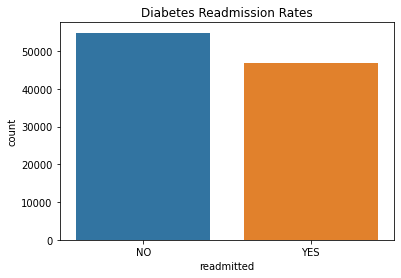

In [10]:
x = diabetes['readmitted']
ax = sns.countplot(x=x, data = diabetes).set(title = 'Diabetes Readmission Rates')

,Missing_Number,Missing_Percent
,0,0
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0


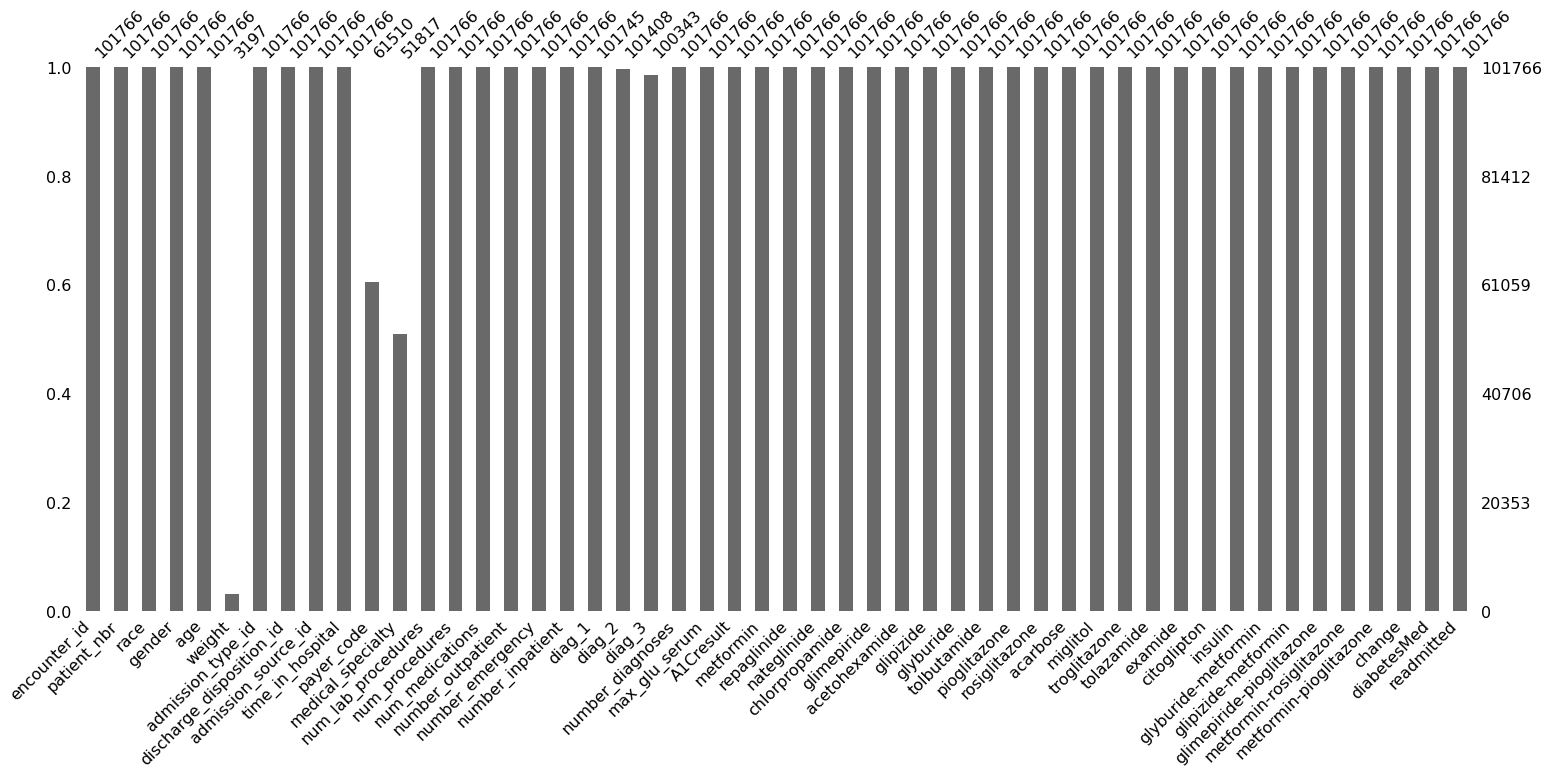

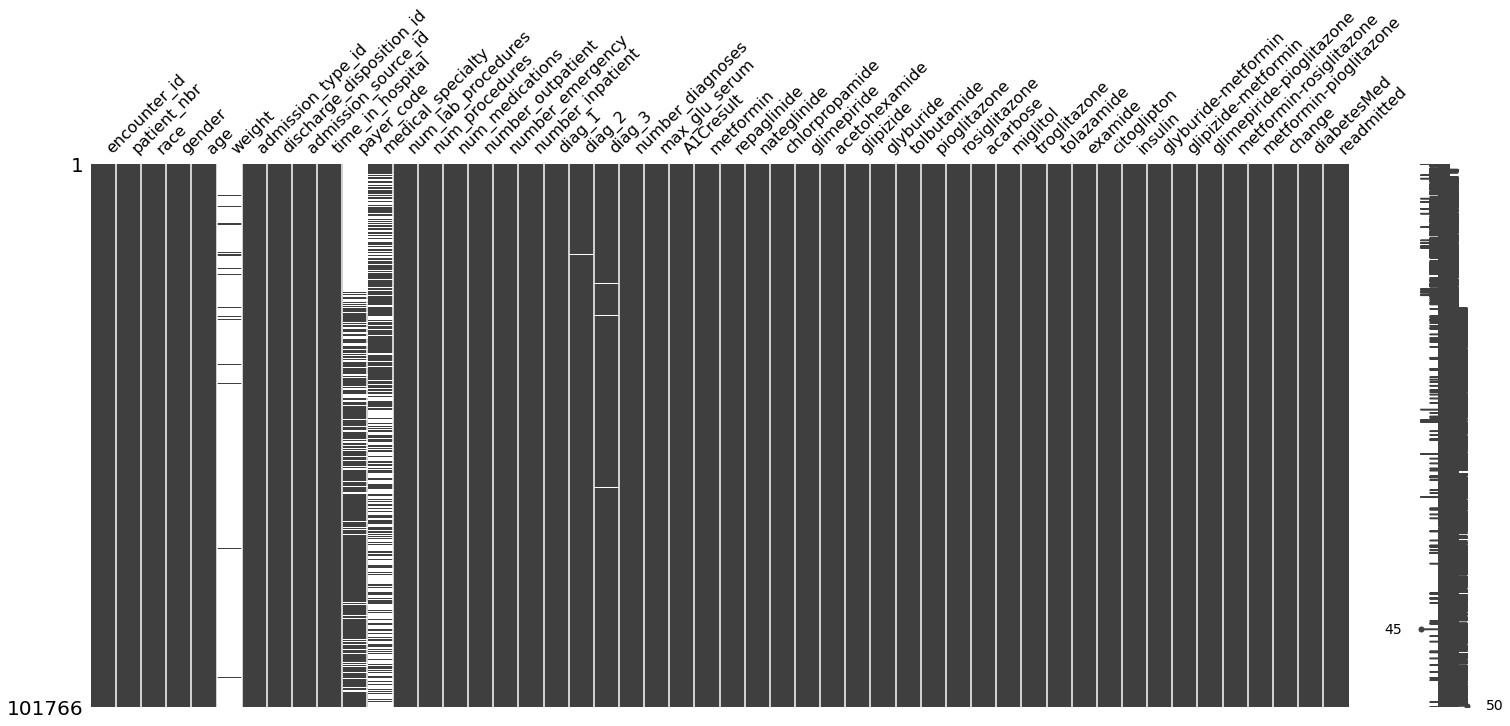

In [11]:
def missing (i):
    i.replace('NaN', np.nan, inplace = True) #replace previous 'nan' with np.nan for counting missing values  
    missing_number = i.isnull().sum().sort_values(ascending=False).to_frame()
    missing_percent = (i.isnull().sum()/i.isnull().count()).sort_values(ascending=False).round(3).to_frame()
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    missing_values['Missing_Percent'] = missing_values["Missing_Percent"]*100
    return missing_values

display(missing(diabetes).head(6))
msno.bar(diabetes)
msno.matrix(diabetes)

In [12]:
num = list(diabetes.select_dtypes(['int64']).columns)
num_exclude = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
num_cleaned = [x for x in num if x not in num_exclude]
cat = list(diabetes.select_dtypes(['object']).columns)

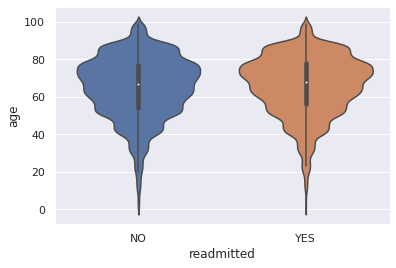

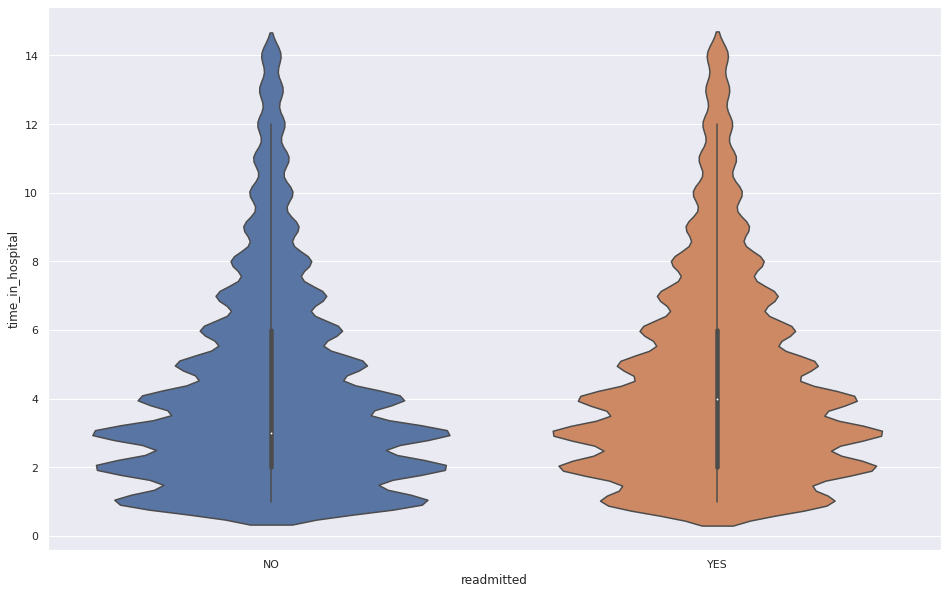

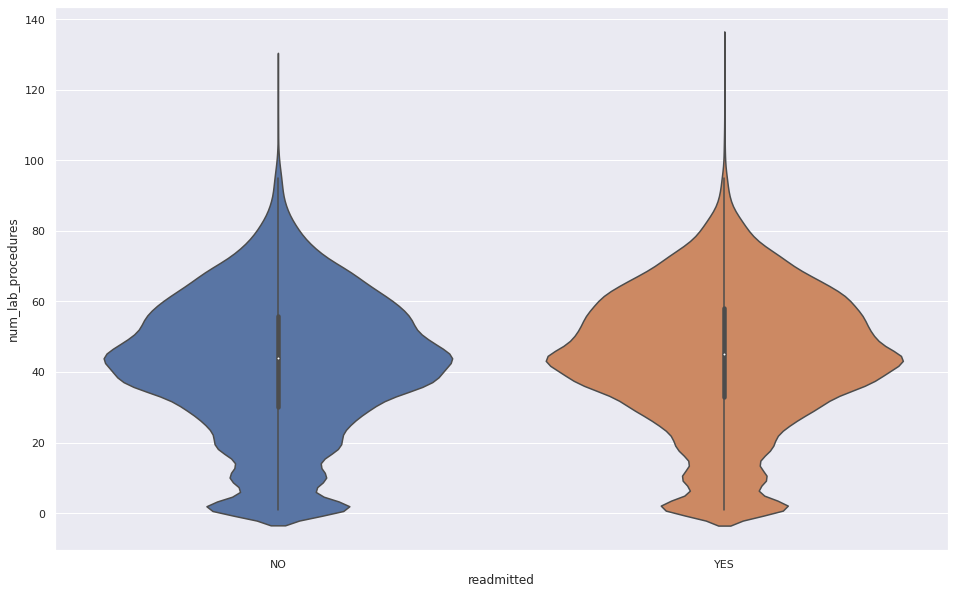

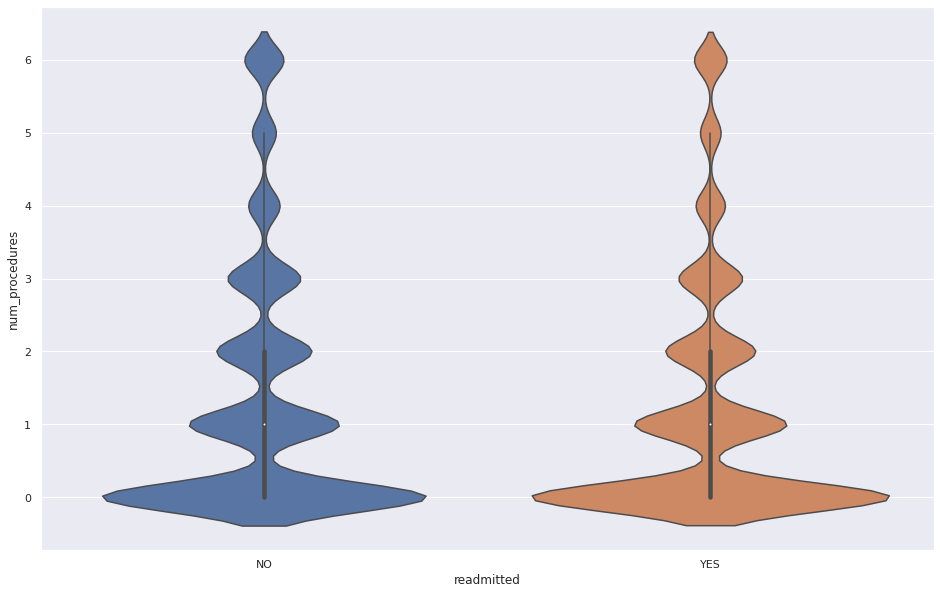

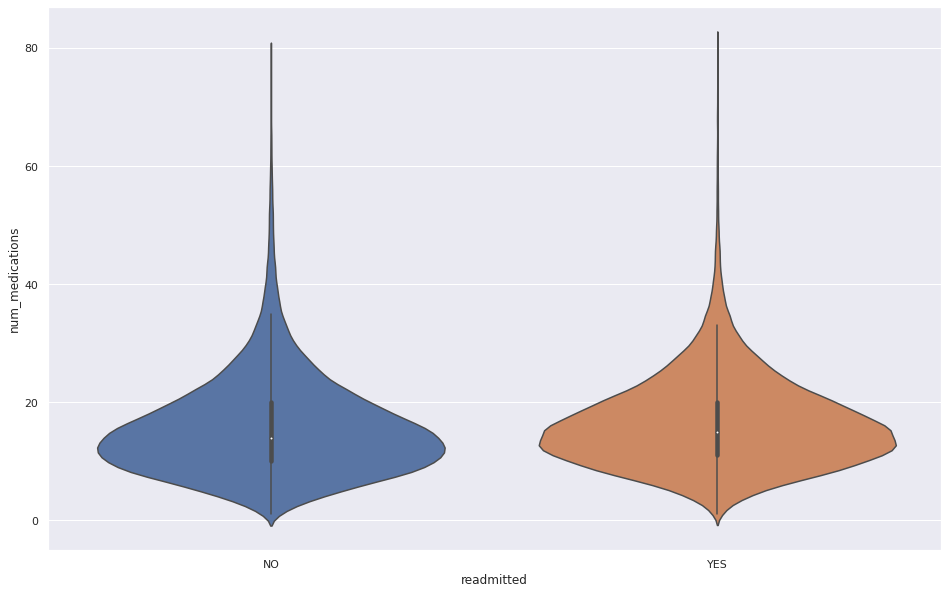

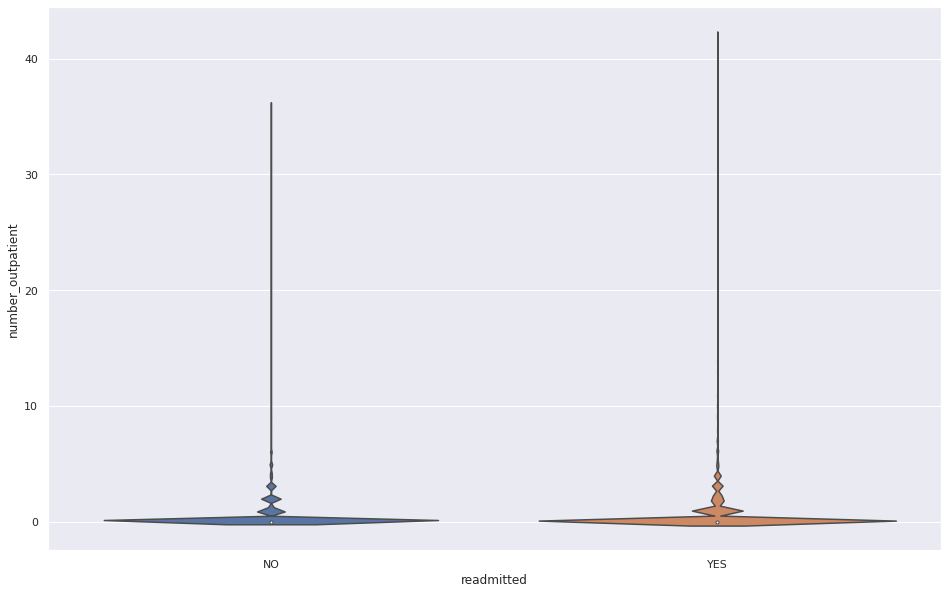

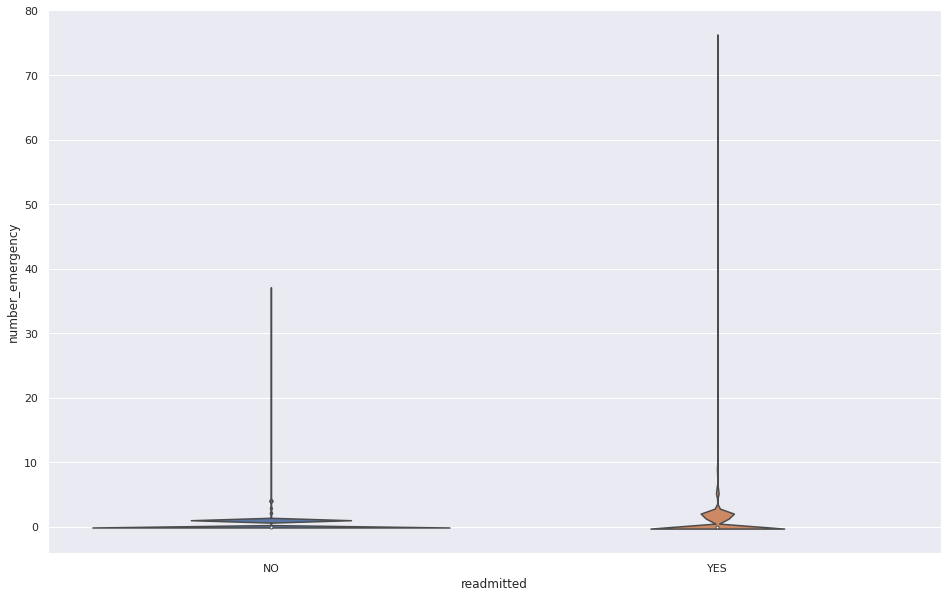

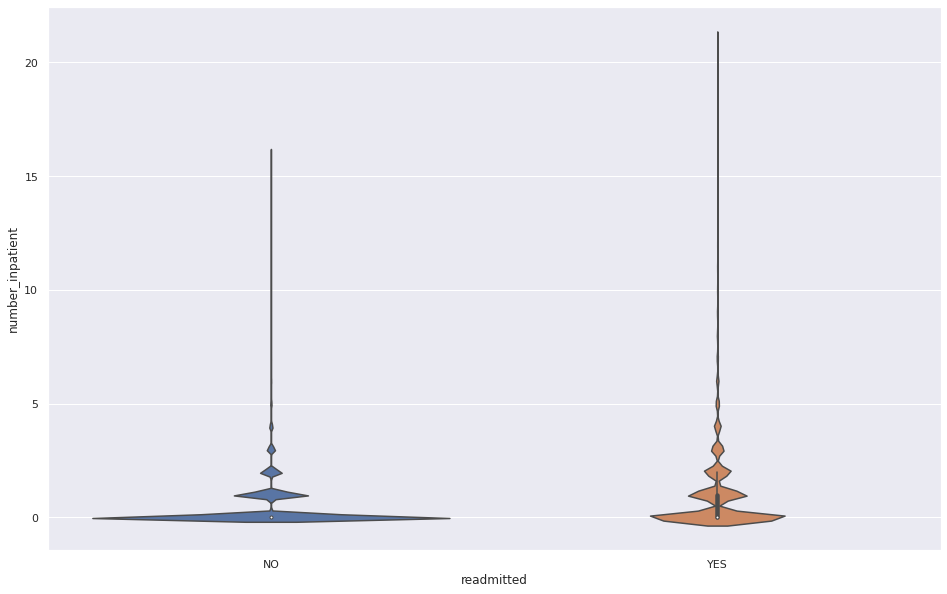

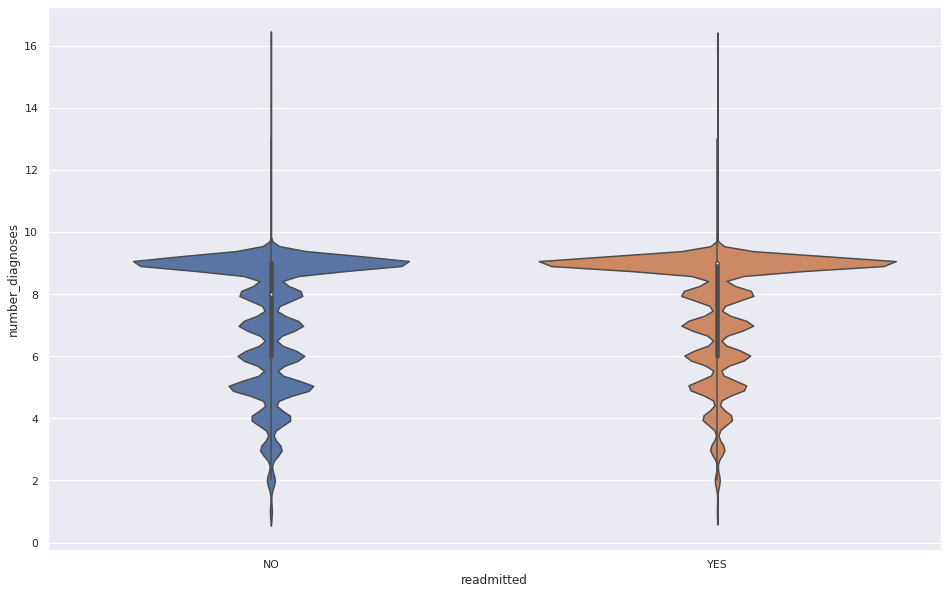

In [13]:
def violin_plots(x,y, data): 
    for i, col in enumerate(y):
        plt.figure(i)
        sns.set(rc = {'figure.figsize' : (16, 10)})
        ax = sns.violinplot(x=x, y = col, data = diabetes)

y = diabetes[num_cleaned]
x = diabetes.columns[-1]

violin_plots(x,y,diabetes)

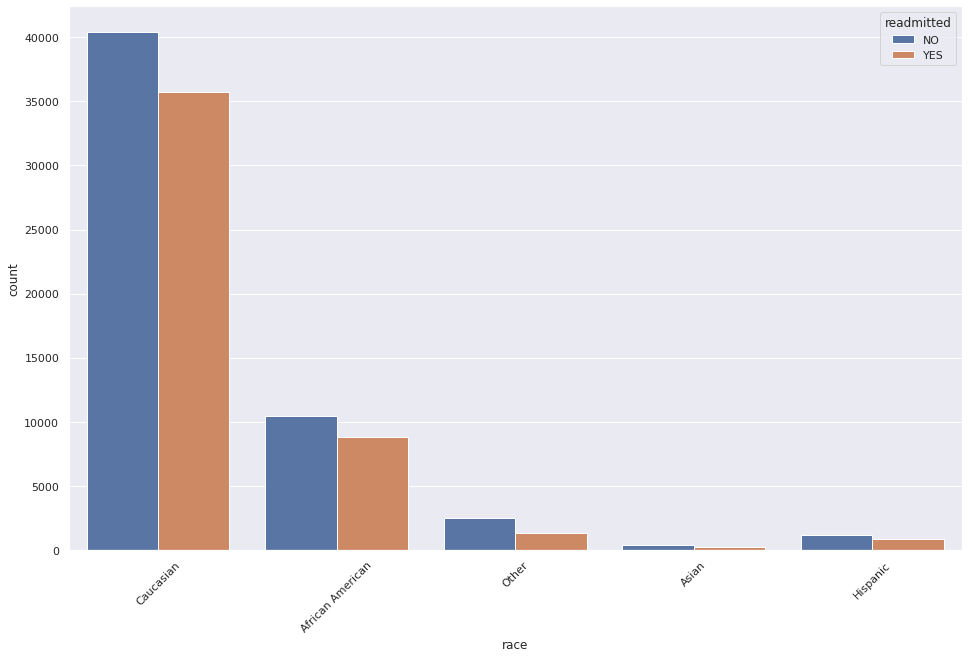

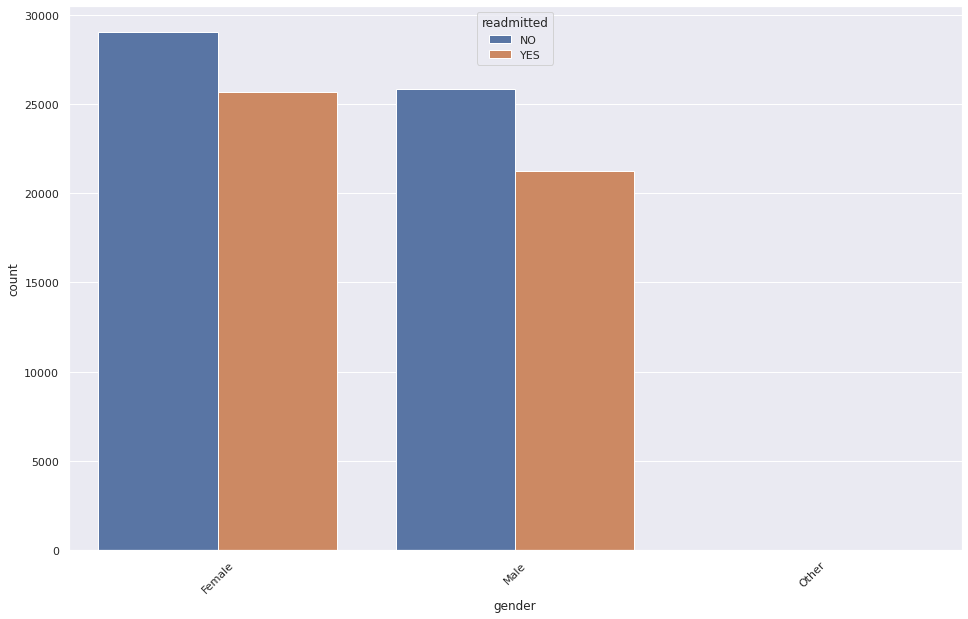

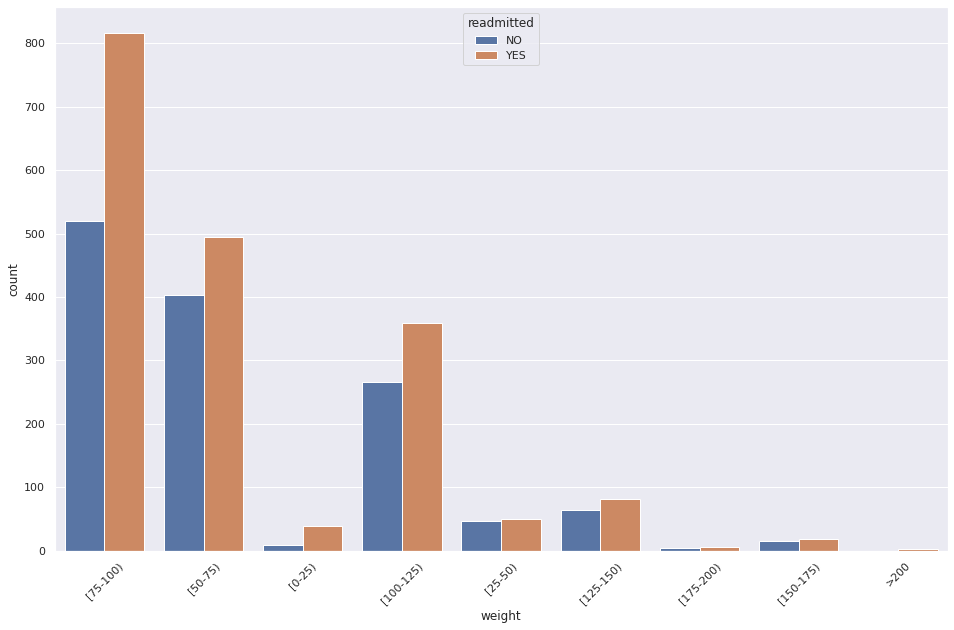

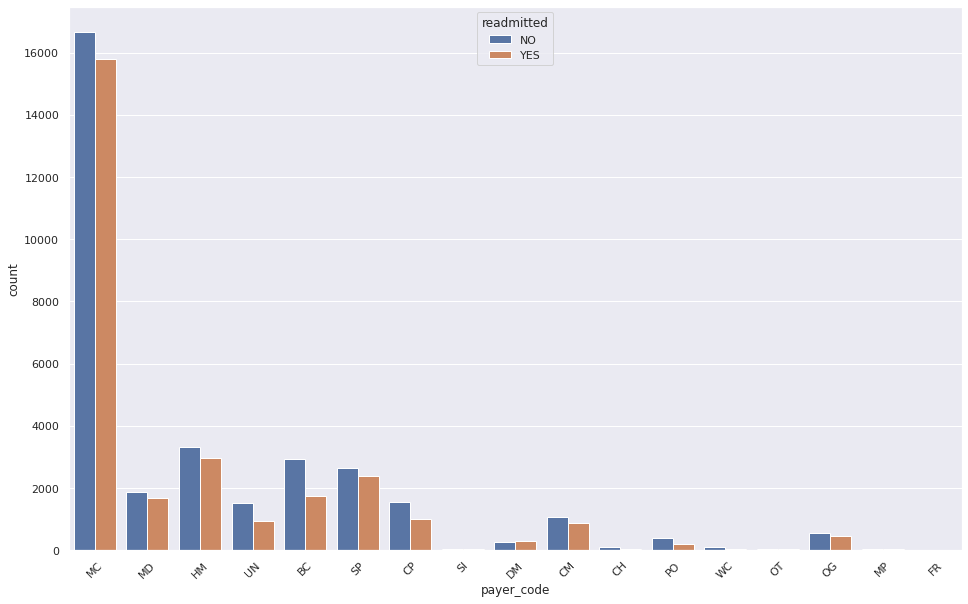

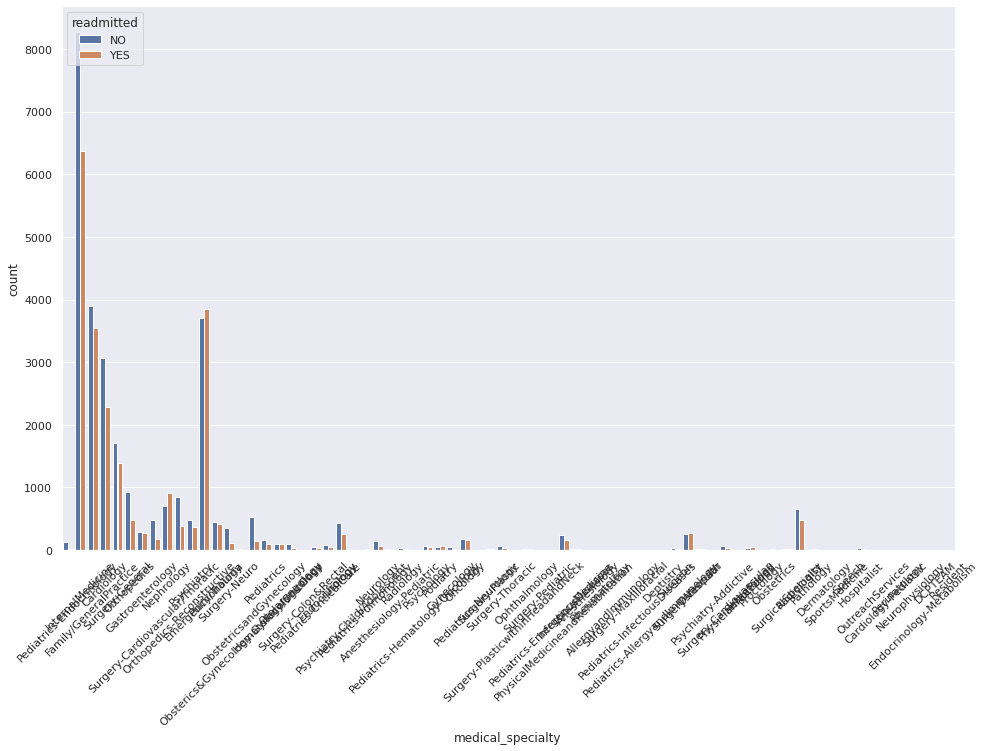

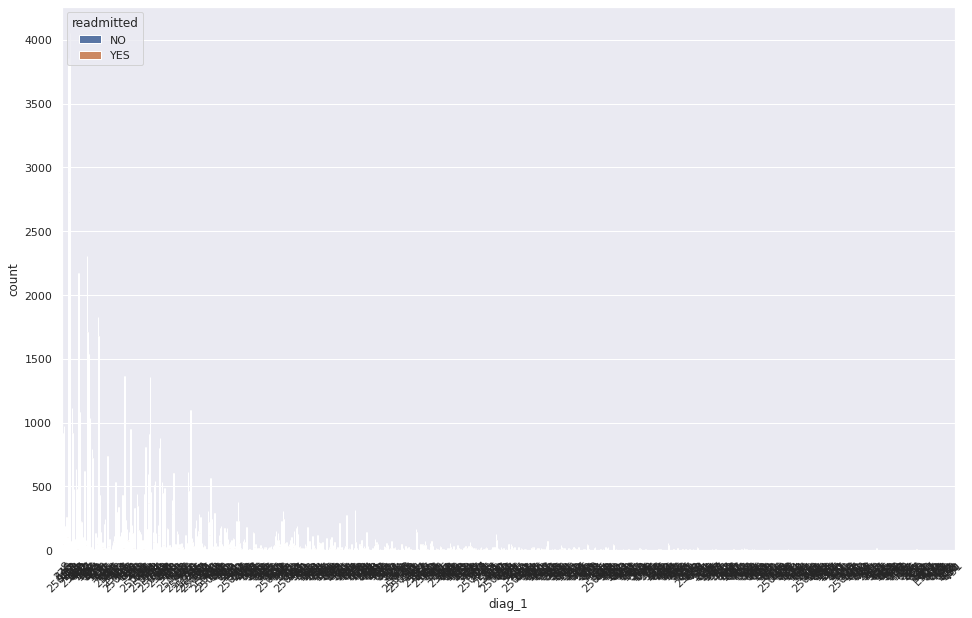

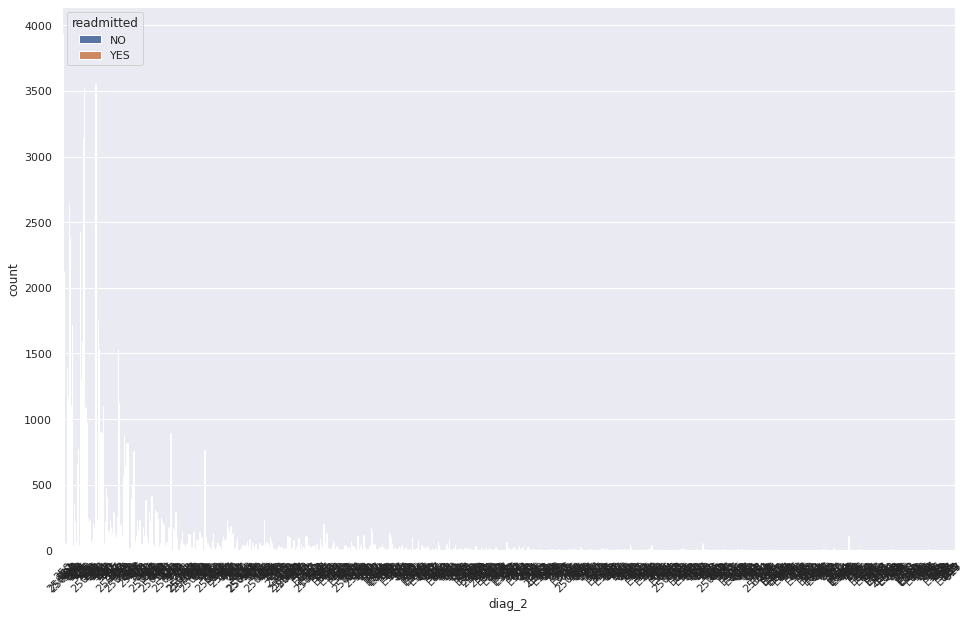

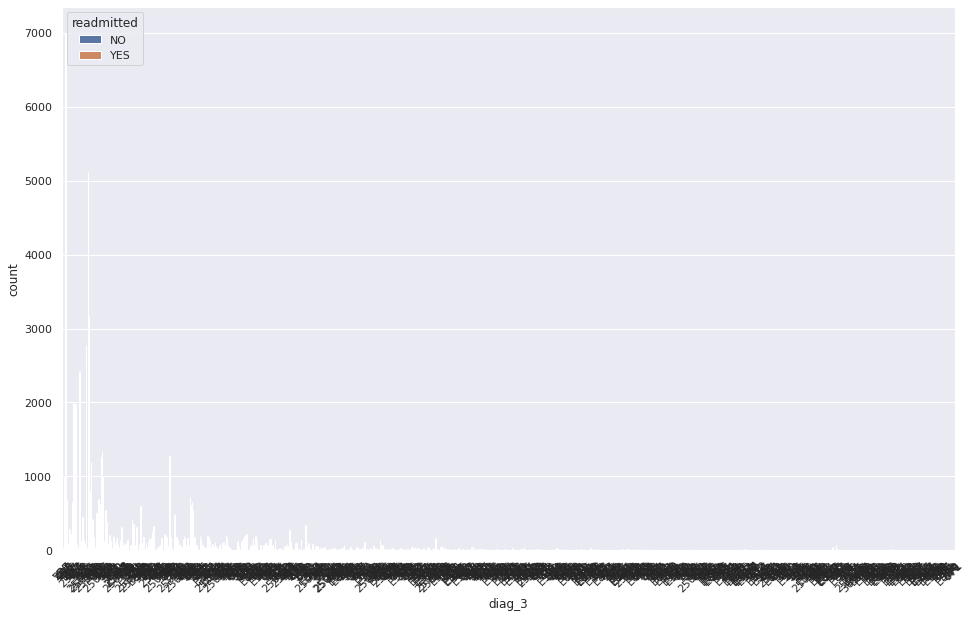

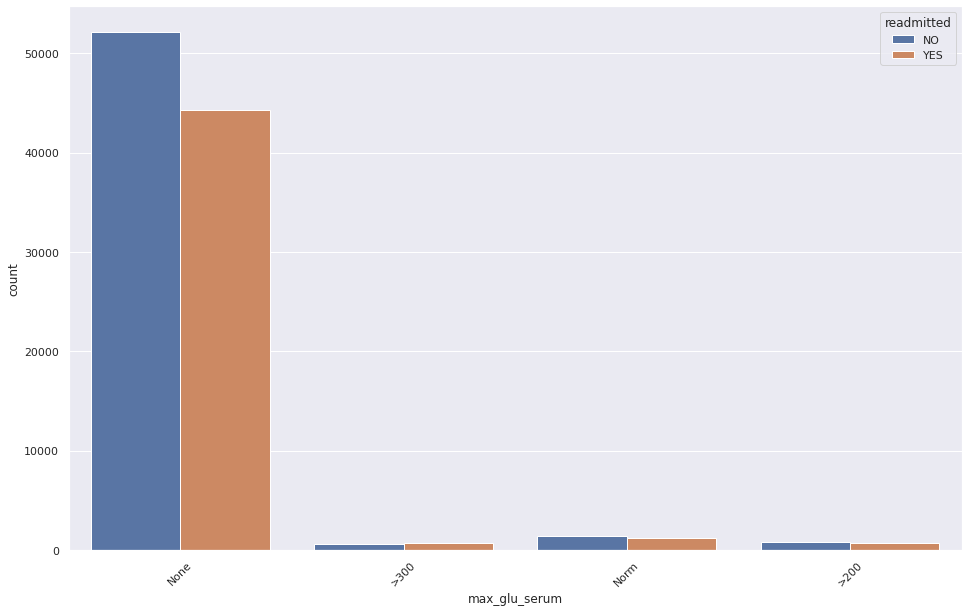

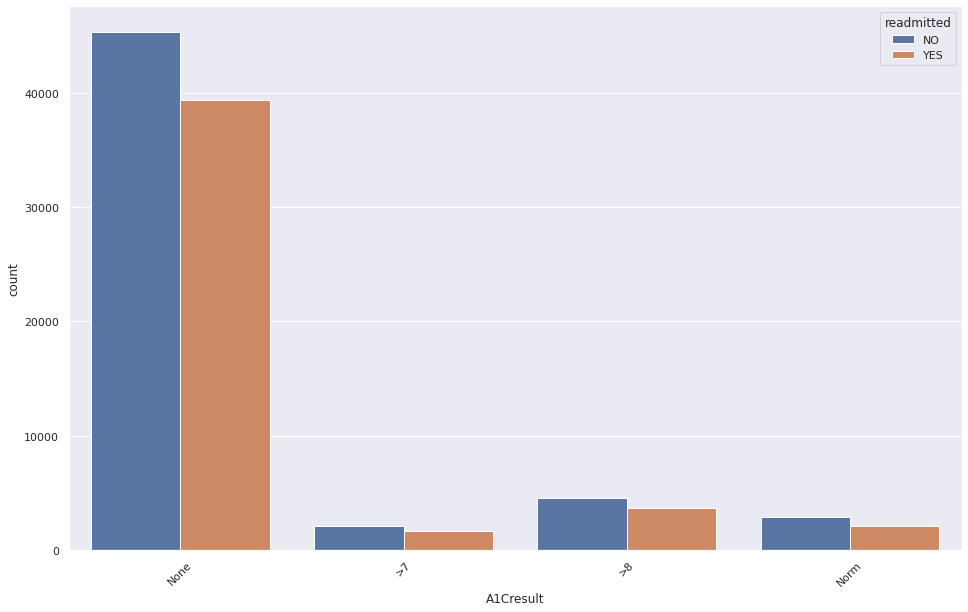

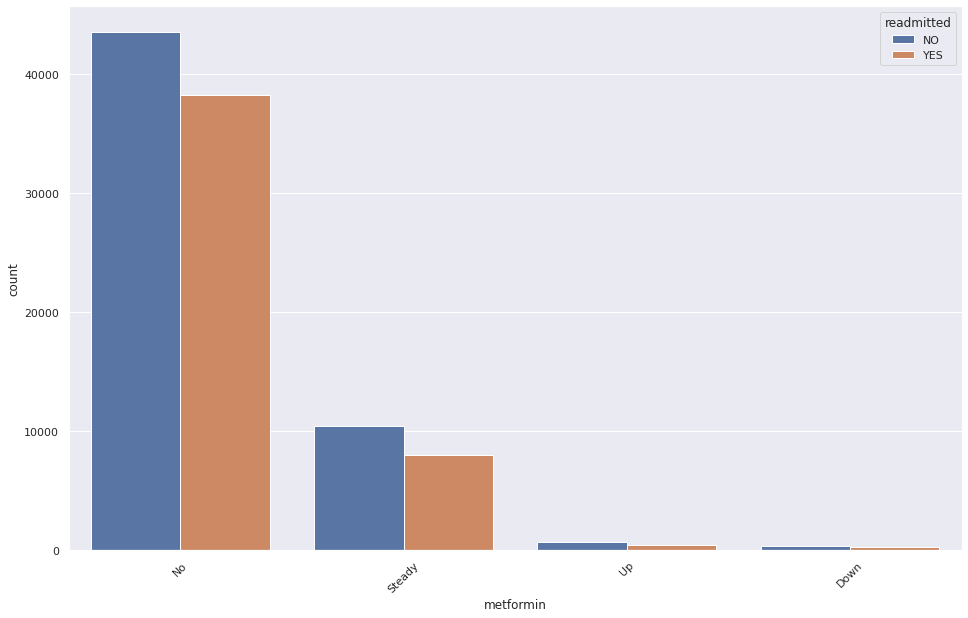

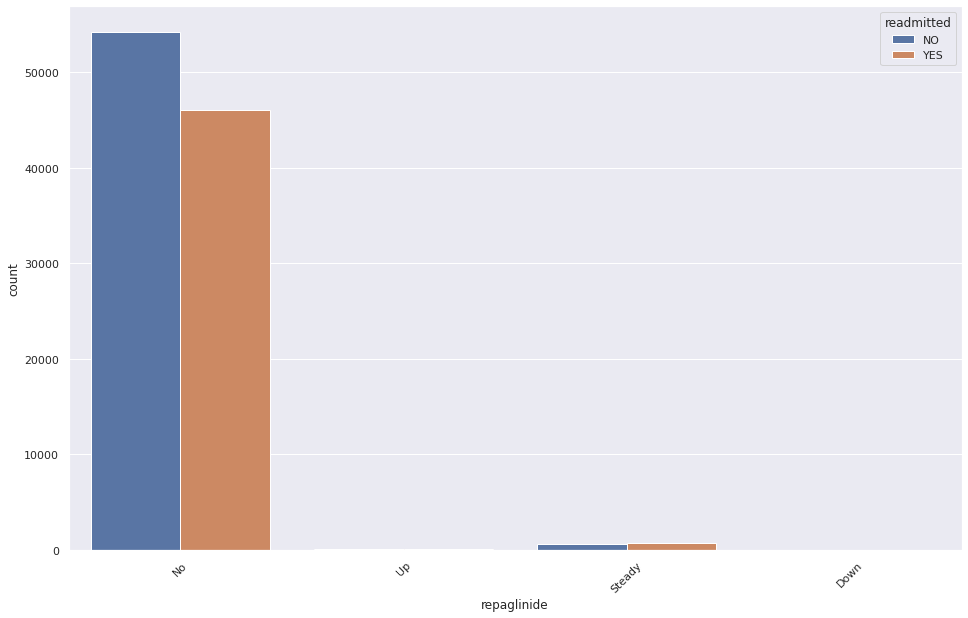

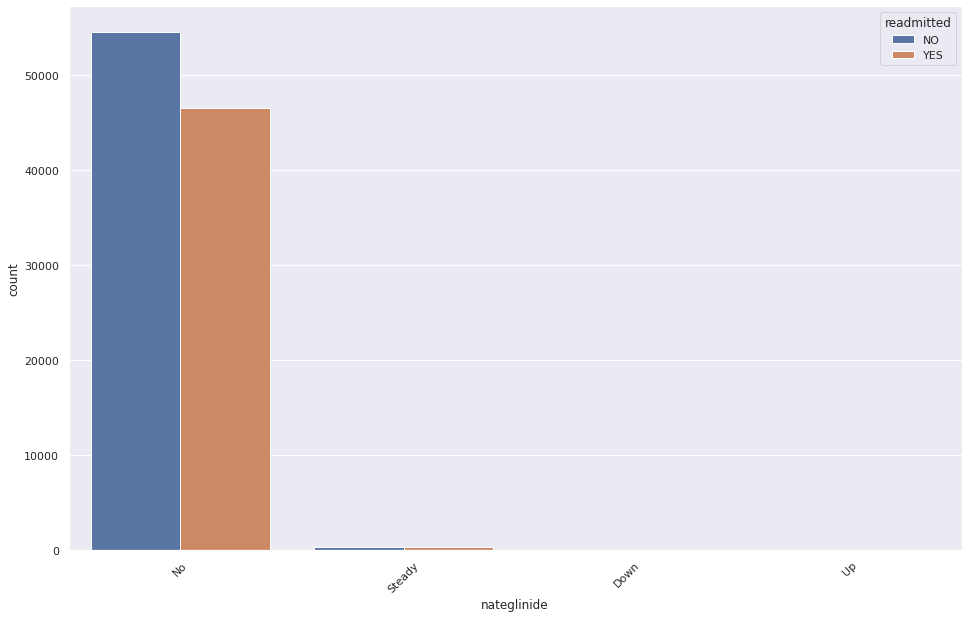

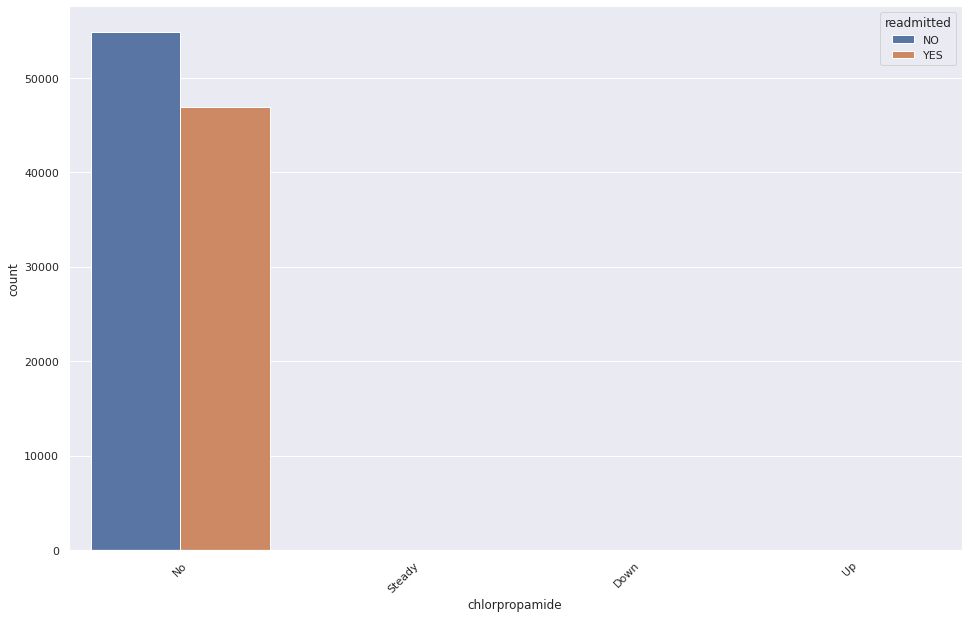

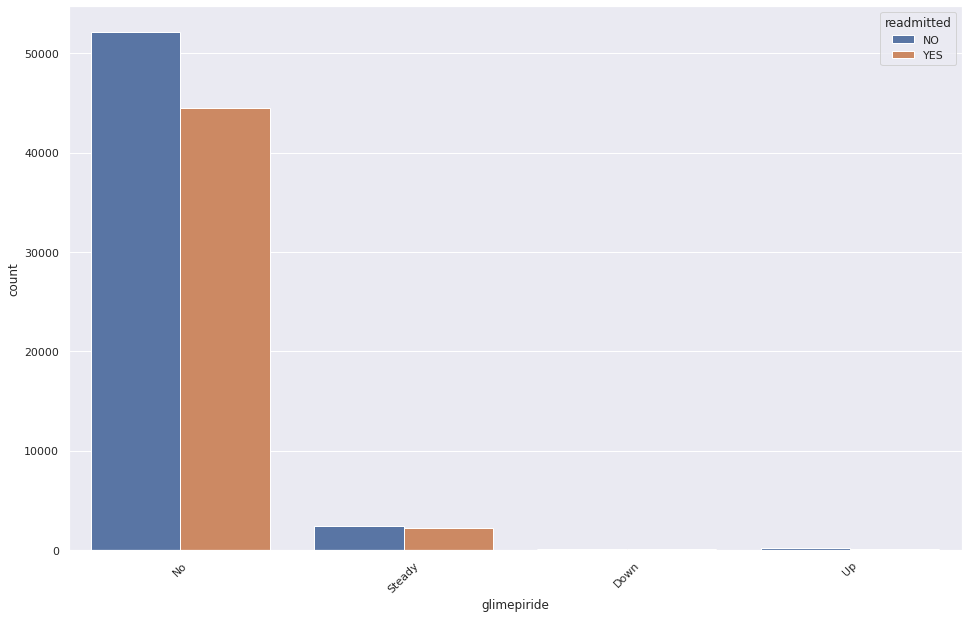

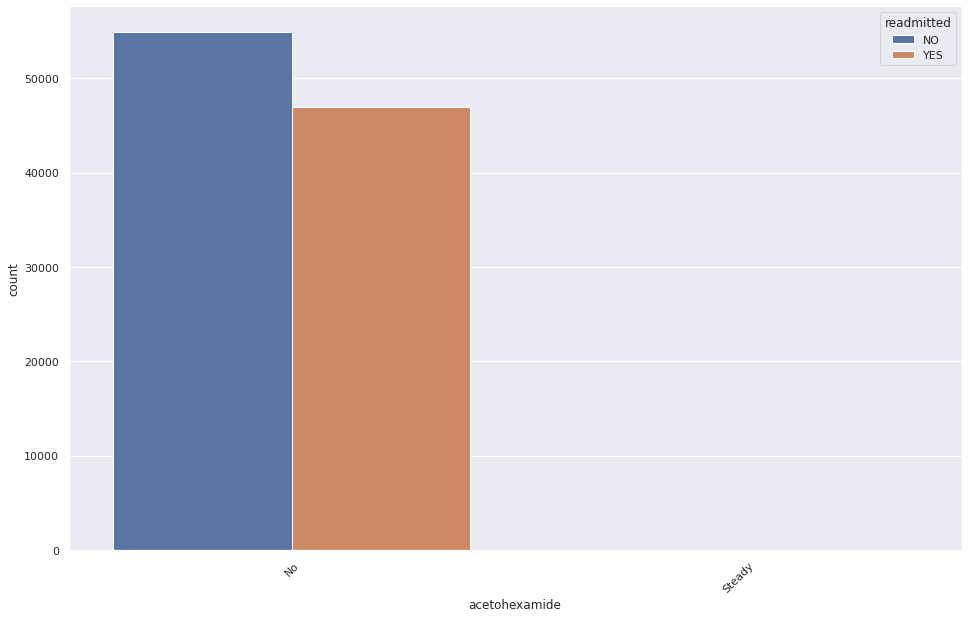

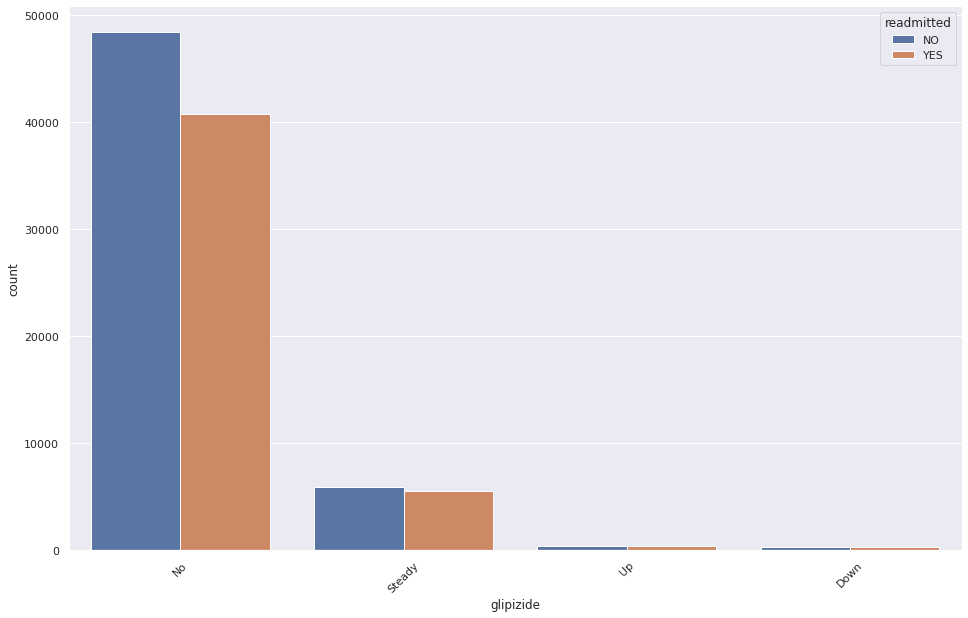

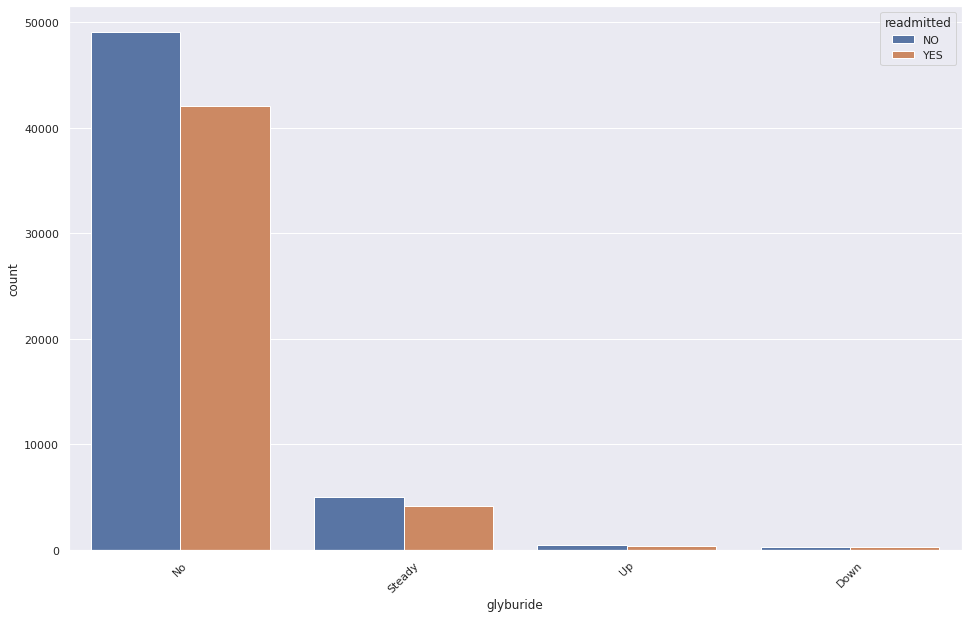

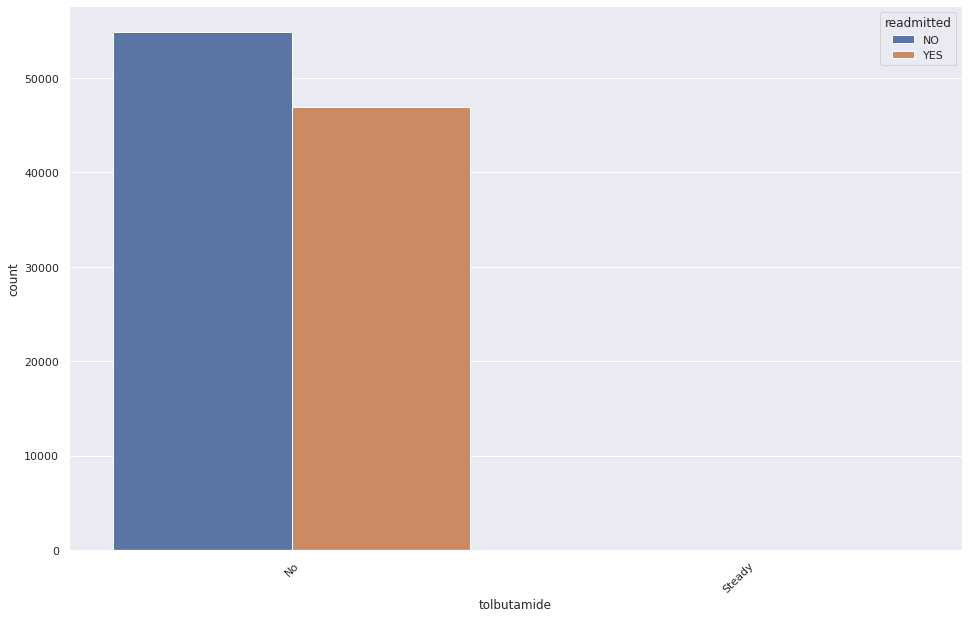

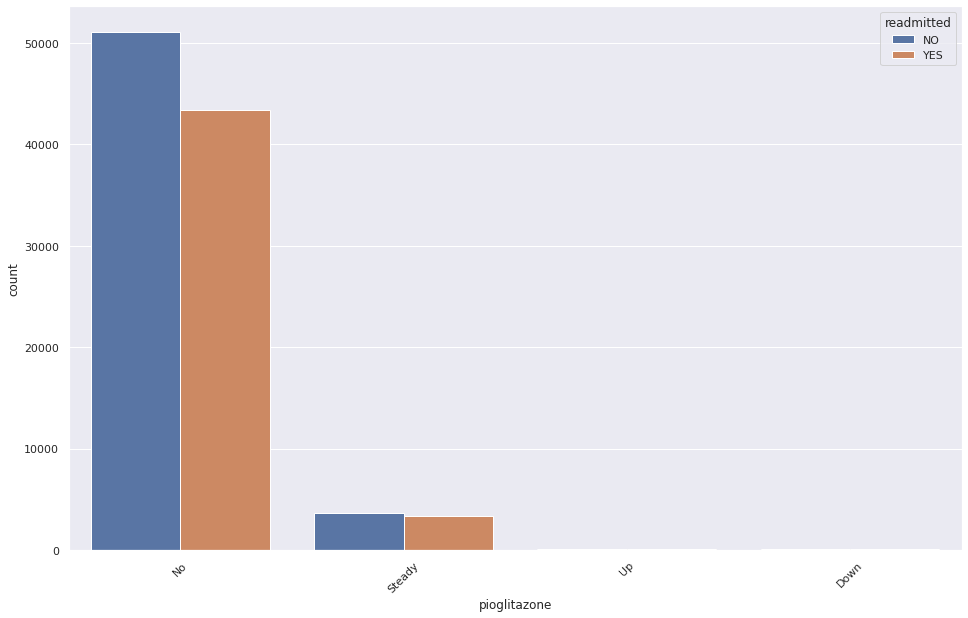

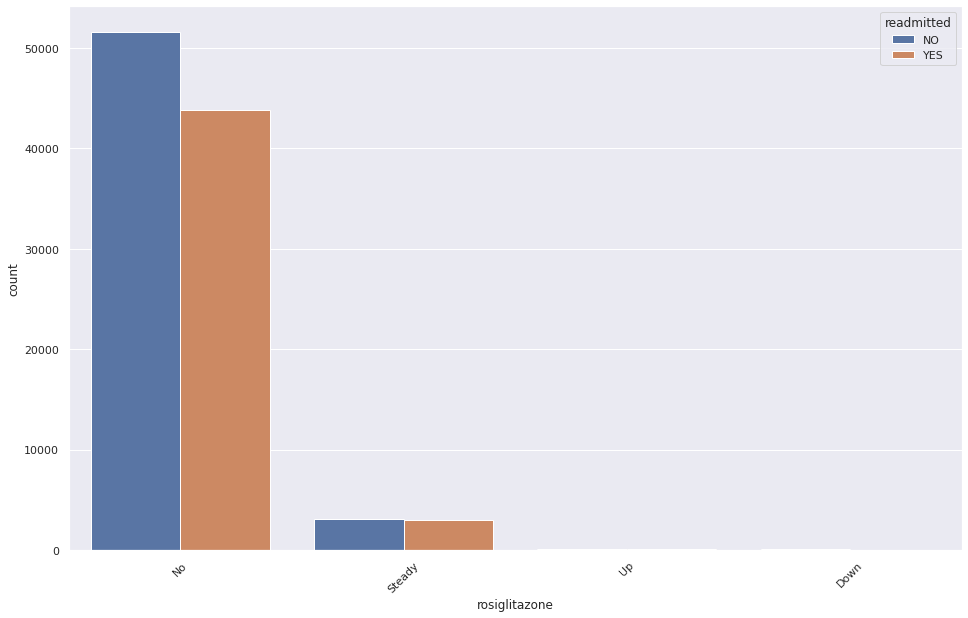

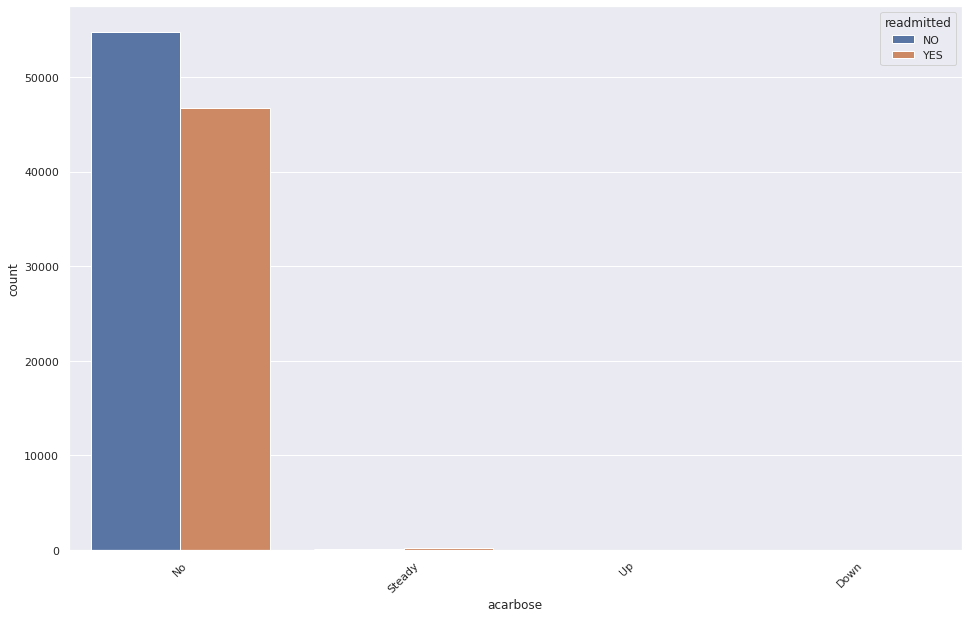

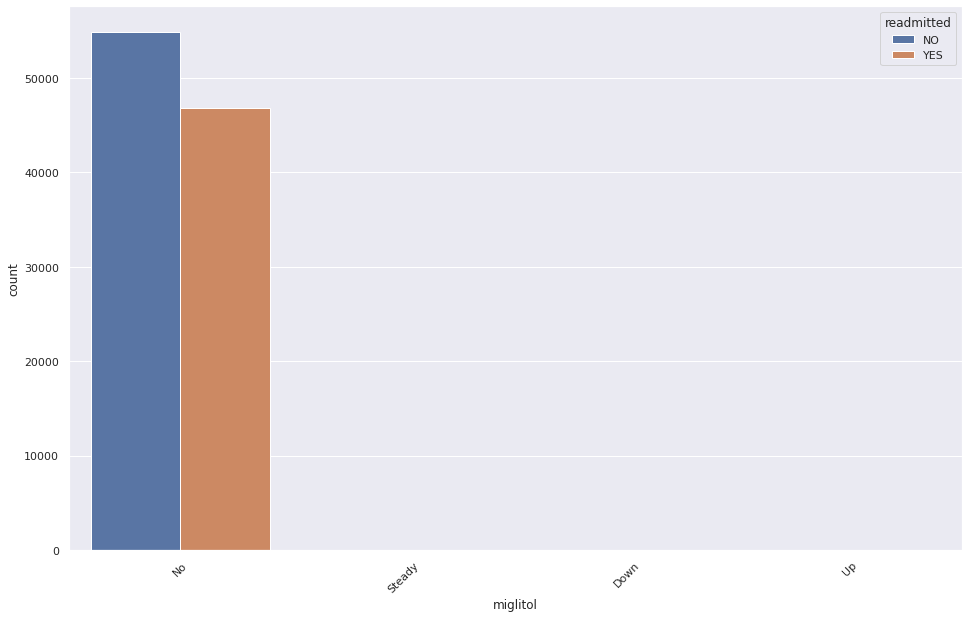

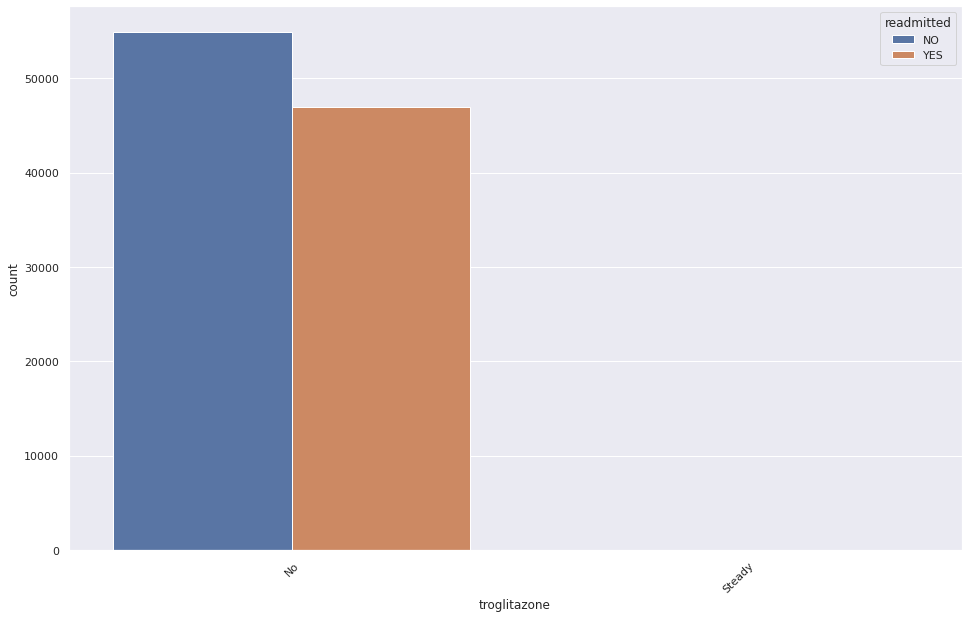

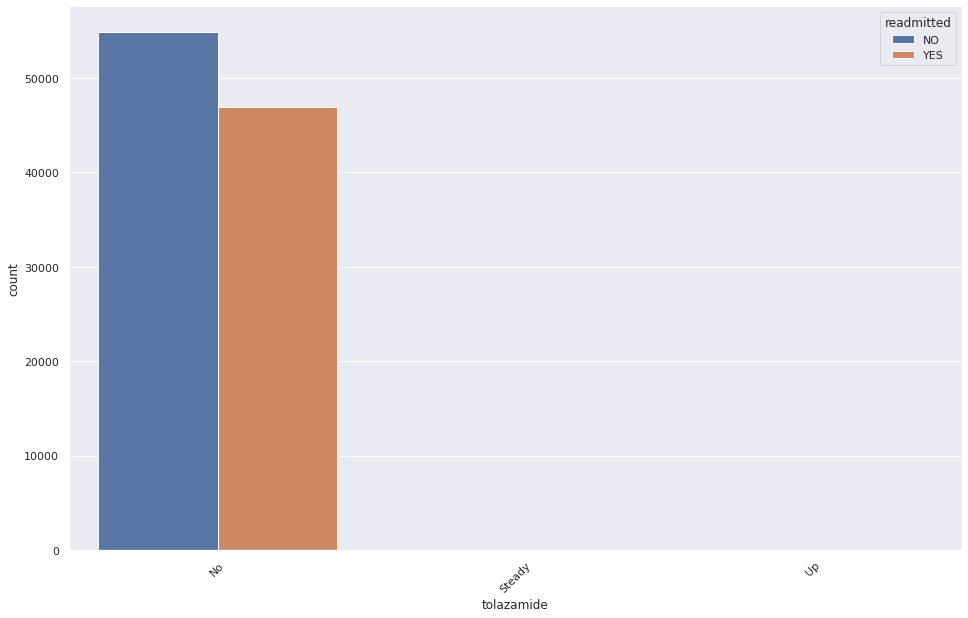

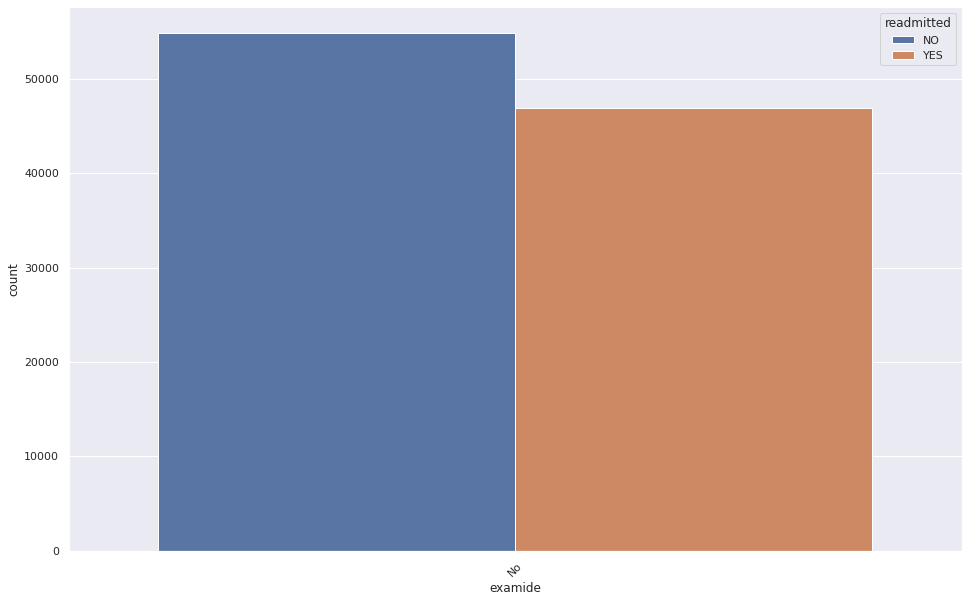

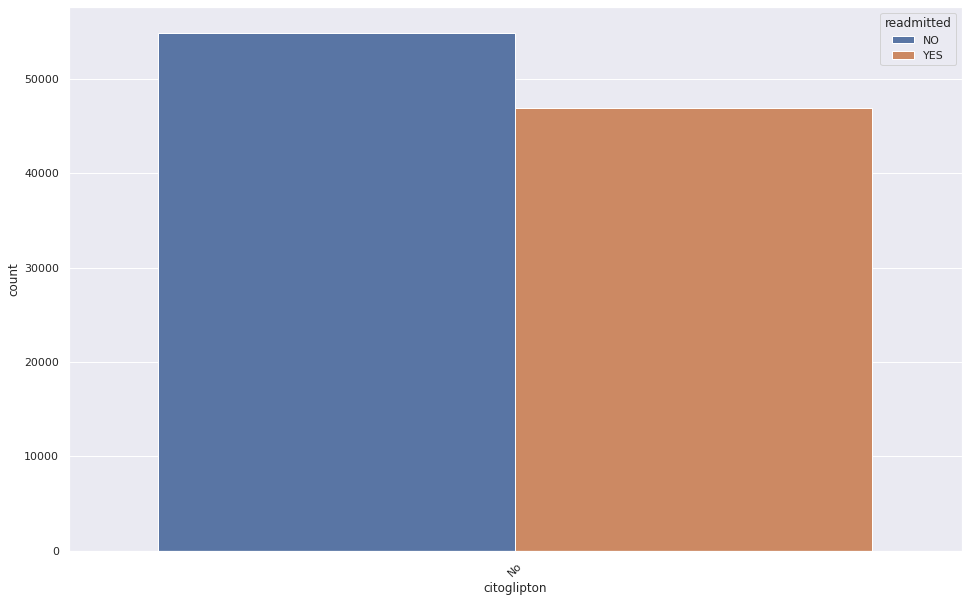

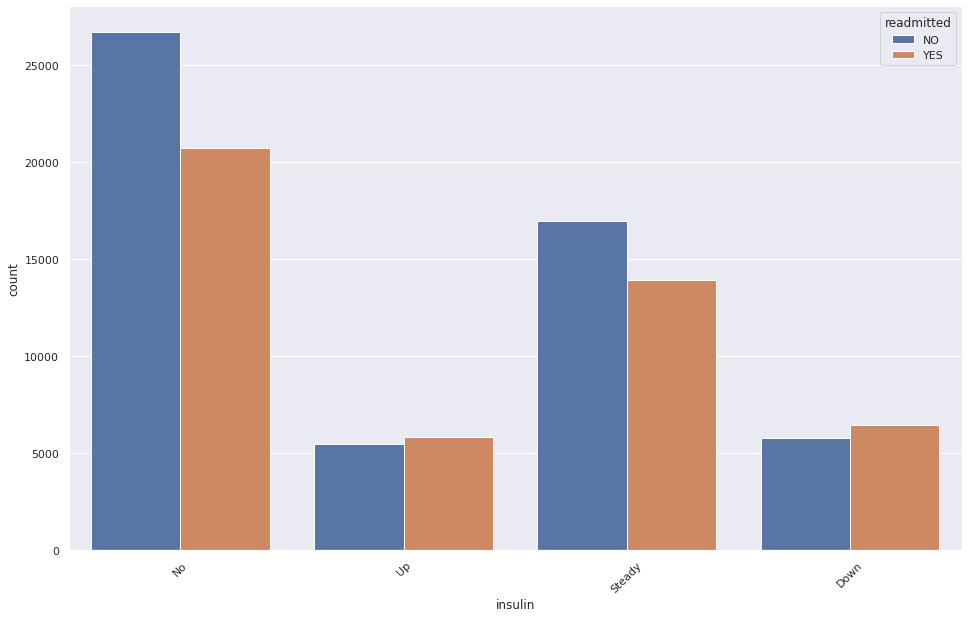

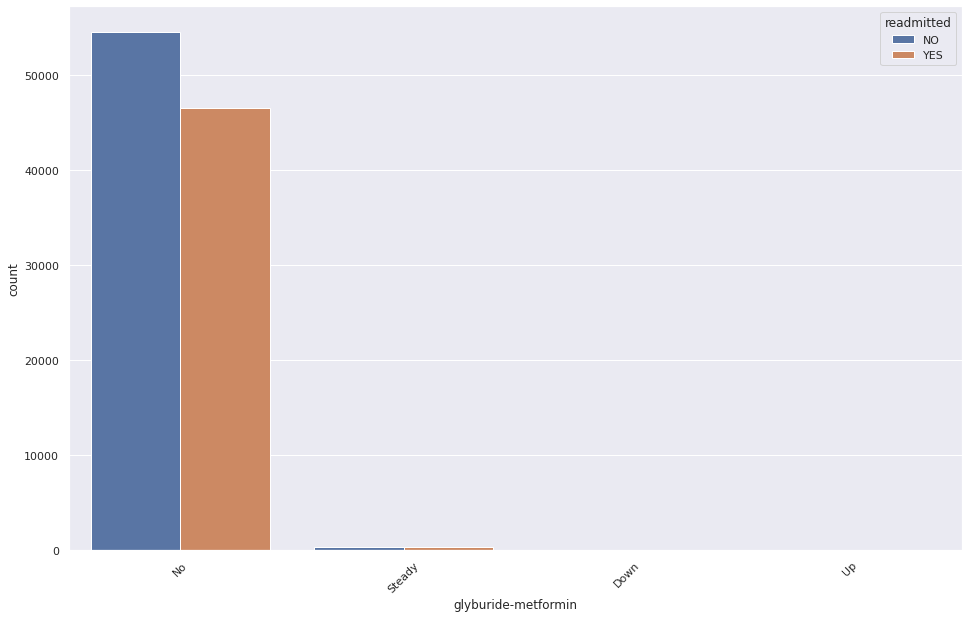

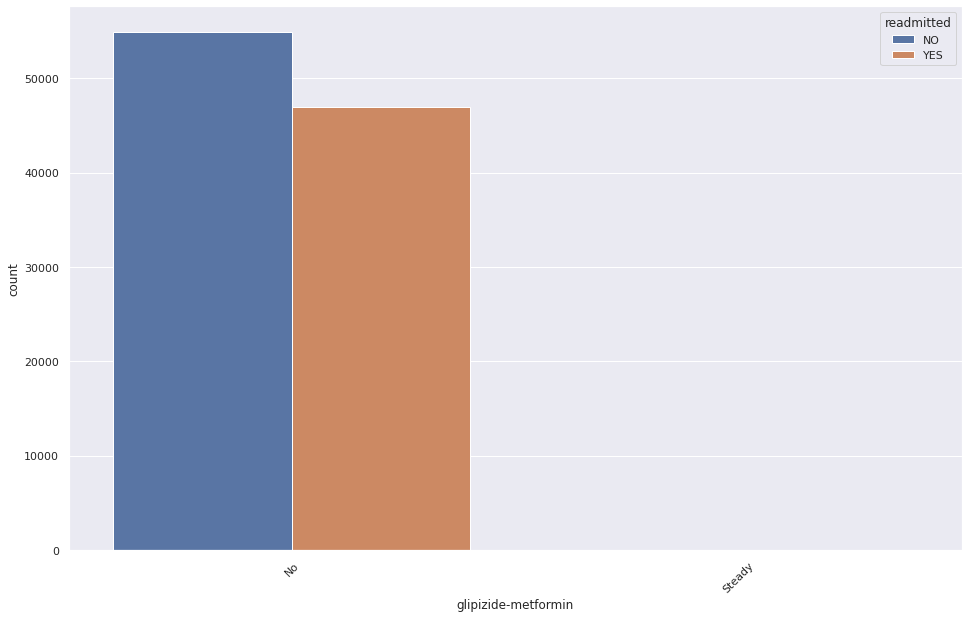

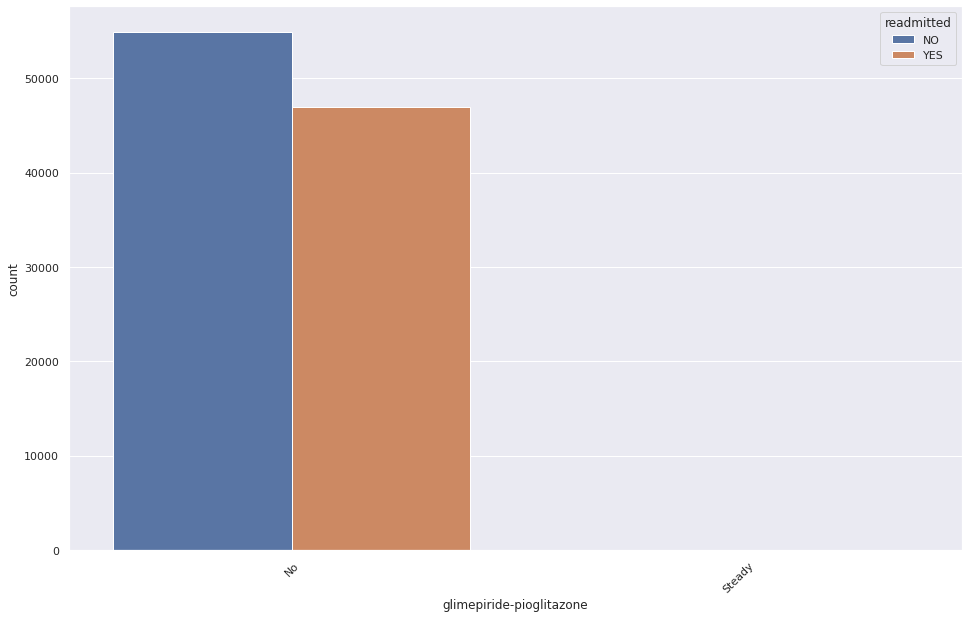

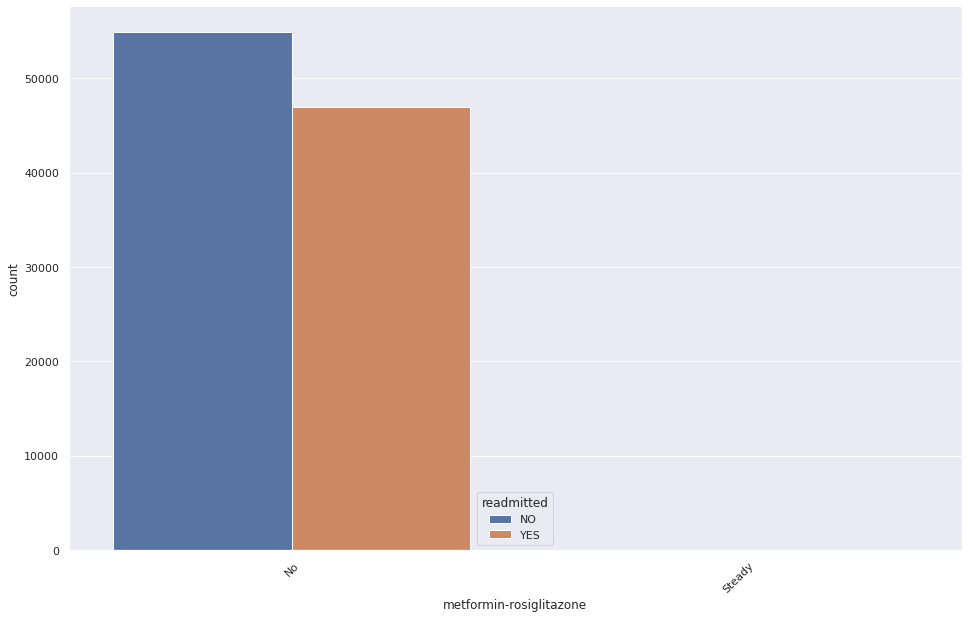

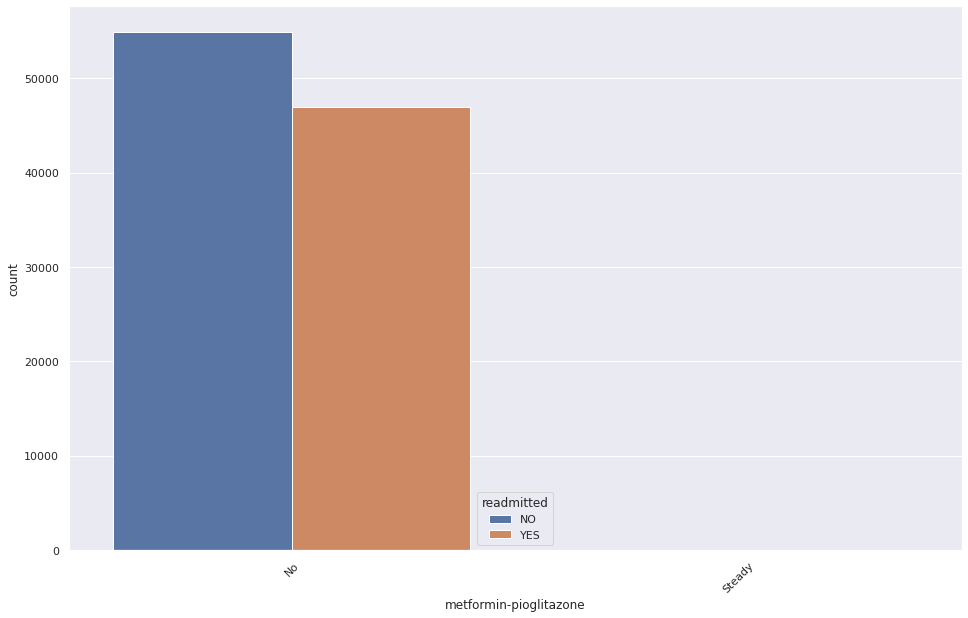

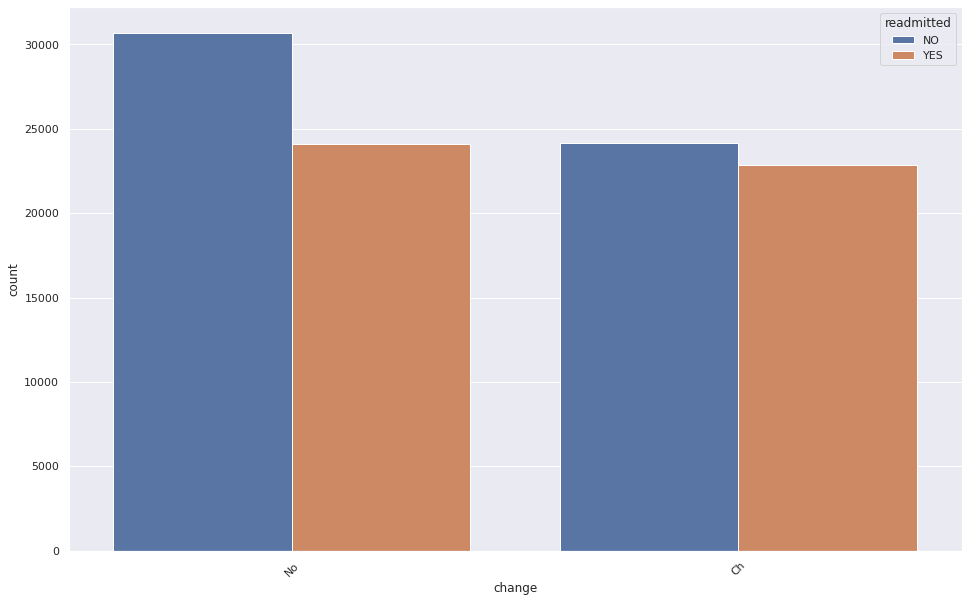

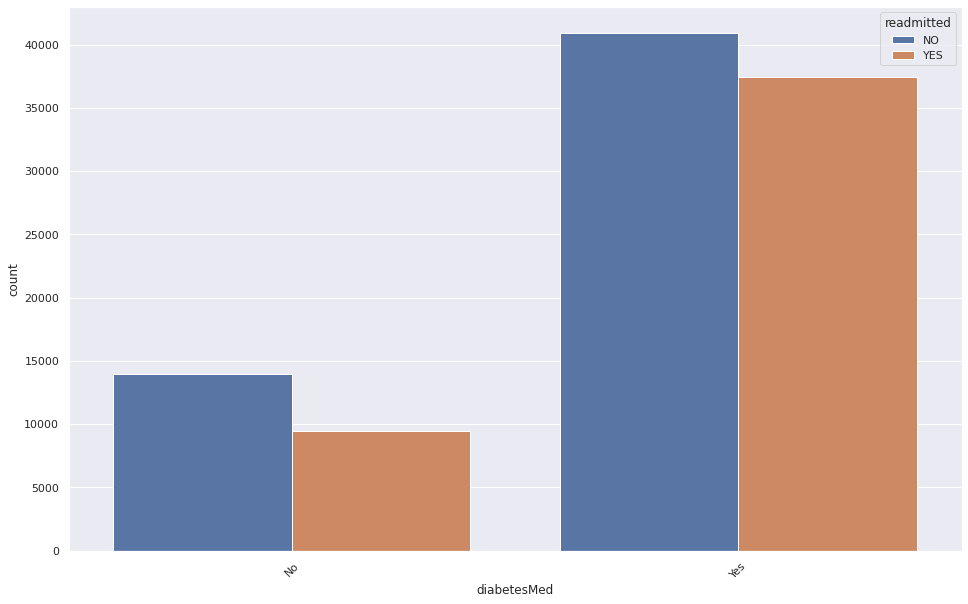

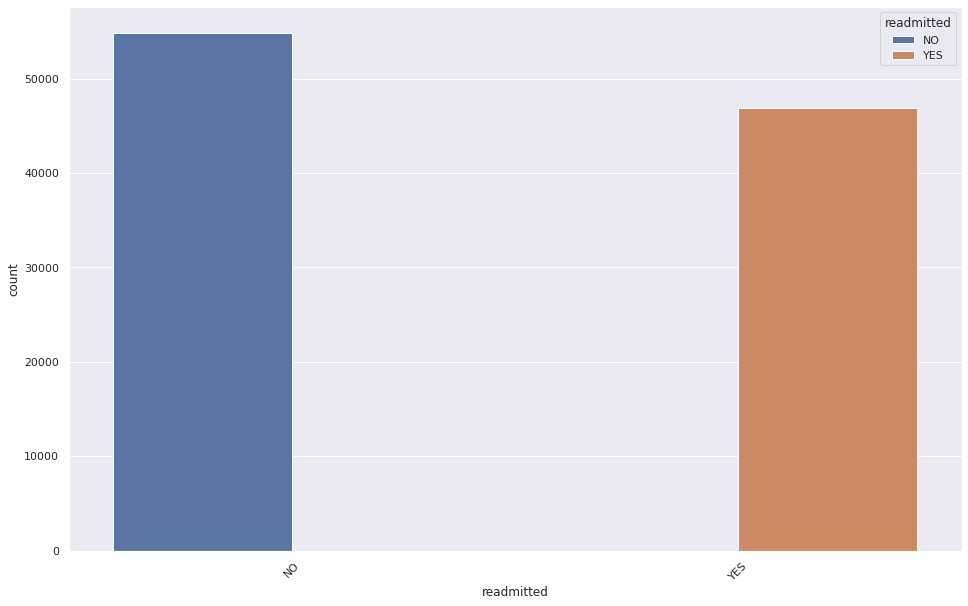

In [14]:
def plot_data(data):
    for i, col in enumerate(diabetes[cat]):
        plt.figure(i)
        ax = sns.countplot(x=data[col], hue= data['readmitted'], data=diabetes)
        plt.xticks(rotation=45)

plot_data(diabetes)

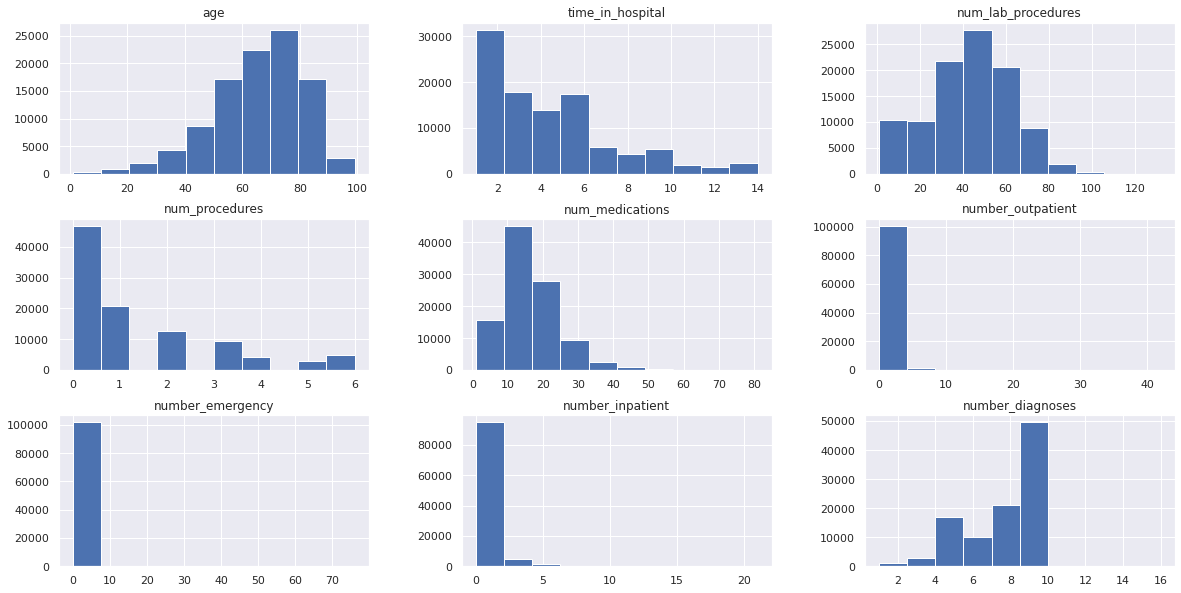

In [15]:
diabetes[num_cleaned].hist(figsize=(20,10));

### Statistics and feature importance 

In [16]:
display(diabetes[num_cleaned].describe())
display(diabetes[num_cleaned].corr())
display(diabetes[num_cleaned].skew())
print('')
display(diabetes[num_cleaned].kurtosis())

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,65.481035,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,16.199287,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,55.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,67.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,77.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,99.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
age,1.000000,0.105264,0.019415,-0.029512,0.040898,0.023548,-0.086808,-0.042387,0.238474
time_in_hospital,0.105264,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186
num_lab_procedures,0.019415,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773
num_procedures,-0.029512,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734
num_medications,0.040898,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526
number_outpatient,0.023548,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152
number_emergency,-0.086808,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539
number_inpatient,-0.042387,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710
number_diagnoses,0.238474,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000


age                   -0.599849
time_in_hospital       1.133999
num_lab_procedures    -0.236544
num_procedures         1.316415
num_medications        1.326672
number_outpatient      8.832959
number_emergency      22.855582
number_inpatient       3.614139
number_diagnoses      -0.876746
dtype: float64

age                      0.247242
time_in_hospital         0.850251
num_lab_procedures      -0.245074
num_procedures           0.857110
num_medications          3.468155
number_outpatient      147.907736
number_emergency      1191.686726
number_inpatient        20.719397
number_diagnoses        -0.079056
dtype: float64

In [17]:
diabetes.groupby('readmitted')[num_cleaned].mean()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
readmitted,,,,,,,,,
NO,65.040209,4.254429,42.381598,1.410305,15.670367,0.273112,0.109216,0.381963,7.221366
YES,65.996695,4.561575,43.930898,1.257175,16.432988,0.481941,0.301501,0.932220,7.658010


In [18]:
t = diabetes['readmitted'].value_counts()
print(f'Original values:\n{t}')
le = LabelEncoder() 
diabetes['readmitted'] = le.fit_transform(diabetes['readmitted'])
t = diabetes['readmitted'].value_counts()
print('\n')
print(f'Modified values:\n{t}')

Original values:
NO     54864
YES    46902
Name: readmitted, dtype: int64


Modified values:
0    54864
1    46902
Name: readmitted, dtype: int64


In [19]:
diabetes[['age', 'time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses', 'readmitted']].corr()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
age,1.000000,0.105264,0.019415,-0.029512,0.040898,0.023548,-0.086808,-0.042387,0.238474,0.029432
time_in_hospital,0.105264,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186,0.051289
num_lab_procedures,0.019415,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773,0.039253
num_procedures,-0.029512,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734,-0.044748
num_medications,0.040898,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526,0.046772
number_outpatient,0.023548,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152,0.082142
number_emergency,-0.086808,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539,0.103011
number_inpatient,-0.042387,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710,0.217194
number_diagnoses,0.238474,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000,0.112564
readmitted,0.029432,0.051289,0.039253,-0.044748,0.046772,0.082142,0.103011,0.217194,0.112564,1.000000


In [20]:
diabetes.drop(columns = {'encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3'}, inplace= True)
diabetes.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin   

In [21]:
cat = list(diabetes.select_dtypes(['object']).columns)
def cat_mut_inf(series):
    return mutual_info_score(series, diabetes['readmitted']) 

binary_cat = diabetes[cat].apply(cat_mut_inf)
binary_cat = binary_cat.sort_values(ascending=False).to_frame(name='mutual_info_score')
binary_cat

,mutual_info_score
insulin,0.002339
diabetesMed,0.001903
race,0.001297
change,0.001058
metformin,0.000414
A1Cresult,0.000264
repaglinide,0.000254
max_glu_serum,0.000241
glipizide,0.000223
gender,0.000180


## Preprocessing

In [22]:
print('Before transformation:')
display(diabetes.head(5))
#encoded_data = pd.get_dummies(diabetes, drop_first = False)
to_encode = diabetes.copy(deep = True)
to_encode.columns.astype(str)
encoded_data = pd.get_dummies(to_encode)
print('One hot encoding of all columns:')
display(encoded_data.head(5))
list(encoded_data.columns)

Before transformation:


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,3,6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,18,1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,African American,Female,24,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,32,1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,49,1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


One hot encoding of all columns:


,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,3,6,25,1,1,41,0,1,0,0,...,1,0,1,0,1,0,0,1,1,0
1,18,1,1,7,3,59,0,18,0,0,...,1,0,1,0,1,0,1,0,0,1
2,24,1,1,7,2,11,5,13,2,0,...,1,0,1,0,1,0,0,1,0,1
3,32,1,1,7,2,44,1,16,0,0,...,1,0,1,0,1,0,1,0,0,1
4,49,1,1,7,1,51,0,8,0,0,...,1,0,1,0,1,0,1,0,0,1


['age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'readmitted',
 'race_African American',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'gender_Female',
 'gender_Male',
 'gender_Other',
 'max_glu_serum_>200',
 'max_glu_serum_>300',
 'max_glu_serum_None',
 'max_glu_serum_Norm',
 'A1Cresult_>7',
 'A1Cresult_>8',
 'A1Cresult_None',
 'A1Cresult_Norm',
 'metformin_Down',
 'metformin_No',
 'metformin_Steady',
 'metformin_Up',
 'repaglinide_Down',
 'repaglinide_No',
 'repaglinide_Steady',
 'repaglinide_Up',
 'nateglinide_Down',
 'nateglinide_No',
 'nateglinide_Steady',
 'nateglinide_Up',
 'chlorpropamide_Down',
 'chlorpropamide_No',
 'chlorpropamide_Steady',
 'chlorpropamide_Up',
 'glimepiride_Down',
 'glimepiride_No',
 'glimepiride_Steady',
 'glimepiride_Up',
 'acetohexam

In [23]:
train_df, valid_df, test_df = np.split(encoded_data.sample(frac=1, random_state=42), 
                                       [int(.7*len(encoded_data)), int(0.85*len(encoded_data))])
train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

display(encoded_data.readmitted.value_counts())
display(train_df.readmitted.value_counts())
display(valid_df.readmitted.value_counts())
display(test_df.readmitted.value_counts())

0    54864
1    46902
Name: readmitted, dtype: int64

0    38357
1    32879
Name: readmitted, dtype: int64

0    8263
1    7002
Name: readmitted, dtype: int64

0    8244
1    7021
Name: readmitted, dtype: int64

In [24]:
# unbalanced with more negatives than positives so perform sub-sample
# - only a handful of positive cases 
# - split the training data into positive and negative
rows_pos = train_df.readmitted == 1
df_train_pos = train_df.loc[rows_pos]
df_train_neg = train_df.loc[~rows_pos]

# merge the balanced data
diabetes_df_balanced = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 111)],axis = 0)

# shuffle the order of training samples 
diabetes_df_balanced = diabetes_df_balanced.sample(n = len(diabetes_df_balanced), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d): %.3f'%(len(diabetes_df_balanced), \
                                                calc_prevalence(diabetes_df_balanced.readmitted.values)))
print(f'Dataset:\n{diabetes_df_balanced.readmitted.value_counts()}')

Train balanced prevalence(n = 65758): 0.500
Dataset:
0    32879
1    32879
Name: readmitted, dtype: int64


In [25]:
X_train = diabetes_df_balanced.drop('readmitted',axis=1)
y_train = diabetes_df_balanced['readmitted']
X_valid = valid_df.drop('readmitted',axis=1)
y_valid = valid_df['readmitted']
X_test = test_df.drop('readmitted',axis=1)
y_test = test_df['readmitted']

In [26]:
scaler=StandardScaler()
cols = ['number_diagnoses', 'number_emergency', 'number_inpatient']
X_train[cols] = pd.DataFrame(scaler.fit_transform(X_train[cols]), columns=cols)
X_valid[cols] = pd.DataFrame(scaler.transform(X_valid[cols]), columns=cols)
X_test[cols] = pd.DataFrame(scaler.transform(X_test[cols]), columns=cols)

## Modeling

In [27]:
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh = 0.5):
    '''
    Params:
    1. y_actual: The actual values for the target variable.
    2. y_pred: The predicted values for the target variable.
    3. thresh: The threshold for the probability to be considered as a positive class. Default value 0.5
    
    Return:
    1. AUC
    2. Accuracy
    3. Recall
    4. Precision
    5. F-Score
    6. Specificity
    '''   
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    fscore = f1_score(y_actual,(y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC: %.3f'%auc)
    print('accuracy: %.3f'%accuracy)
    print('recall: %.3f'%recall)
    print('precision: %.3f'%precision)
    print('fscore: %.3f'%fscore)
    print('specificity: %.3f'%specificity)
    print('prevalence: %.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, fscore, specificity

thresh = 0.5

def plot_roc(roc_auc): 
    plt.figure(figsize = (10,10))
    plt.title('Recever Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, c = 'red', label = 'AUC  = %0.3f' % roc_auc) ## approximated to the two decimal places 
    plt.legend(loc ='lower right')
    plt.plot([0,1], [0,1], linestyle = '--') ## reference line to evaluate the roc curve 
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

### Linear Regression 

In [ ]:
s = time.time()

lnr = LinearRegression()
lnr.fit(X_train, y_train)

y_valid_preds = lnr.predict(X_test)
print(y_valid_preds)

e = time.time() 
print(f'\n{e-s}s')

### Logistic Regression 

Logistic Regression
Metrics for Training:
AUC: 0.659
accuracy: 0.614
recall: 0.530
precision: 0.637
fscore: 0.579
specificity: 0.697
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.659
accuracy: 0.621
recall: 0.527
precision: 0.599
fscore: 0.561
specificity: 0.701
prevalence: 0.459
 
The roc_auc is: 65.862%


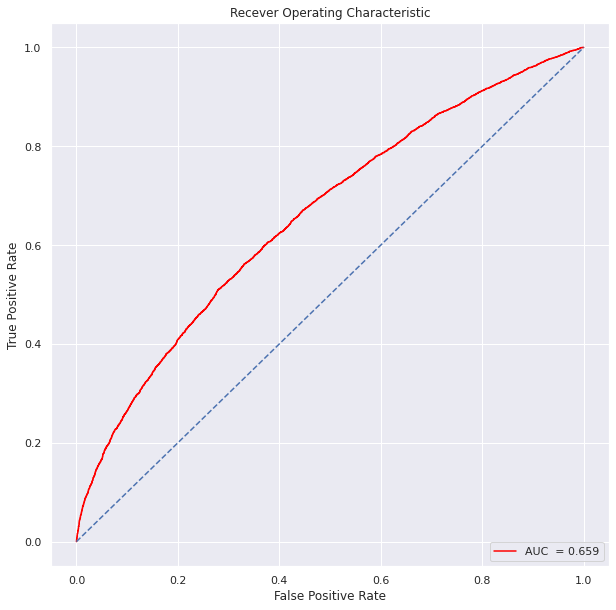

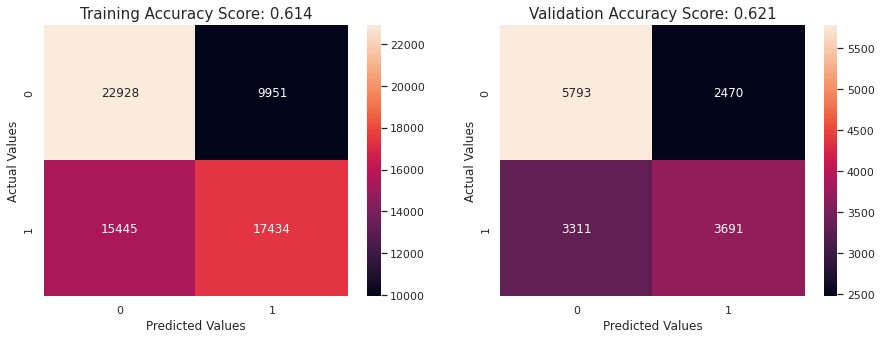


98.19020199775696s


In [28]:
s = time.time()

lr=LogisticRegression(random_state = 42, solver = 'newton-cg', max_iter = 200)
lr.fit(X_train, y_train)

y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_valid)[:,1]

print('Logistic Regression')
print('Metrics for Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_fscore, lr_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_val_fscore, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = lr.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = lr.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### KNN 

KNN
Metrics for Training:
AUC: 0.641
accuracy: 0.599
recall: 0.563
precision: 0.606
fscore: 0.584
specificity: 0.592
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.606
accuracy: 0.578
recall: 0.535
precision: 0.541
fscore: 0.538
specificity: 0.577
prevalence: 0.459
 
The roc_auc is: 60.645%


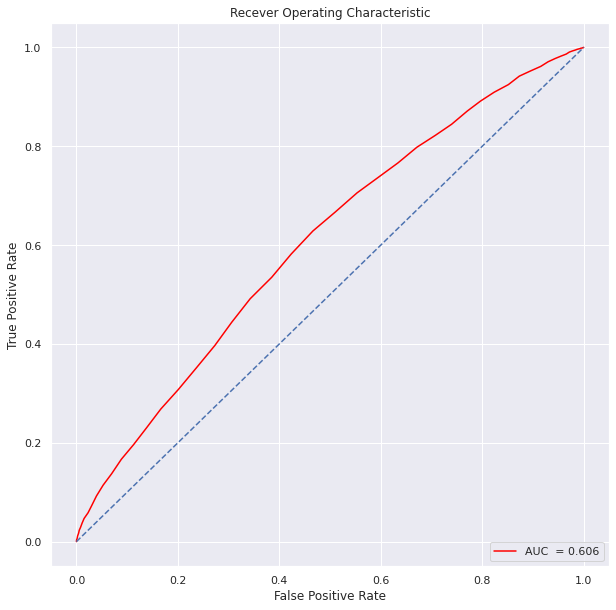

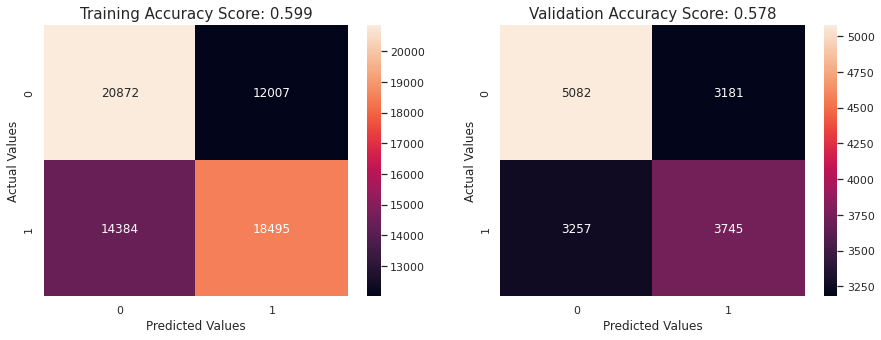


259.7357621192932s


In [29]:
s = time.time()

knn = KNeighborsClassifier(n_neighbors = 100)
# default n_jobs = None
knn.fit(X_train, y_train)

y_train_preds = knn.predict_proba(X_train)[:,1]
y_valid_preds = knn.predict_proba(X_valid)[:,1]

print('KNN')
print('Metrics for Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_fscore, knn_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_val_fscore, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = knn.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = knn.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### Stochastic Gradient Descent

Stochastic Gradient Descent
Metrics for Training:
AUC: 0.648
accuracy: 0.592
recall: 0.767
precision: 0.568
fscore: 0.653
specificity: 0.417
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.651
accuracy: 0.580
recall: 0.769
precision: 0.529
fscore: 0.627
specificity: 0.420
prevalence: 0.459
 
The roc_auc is: 65.089%


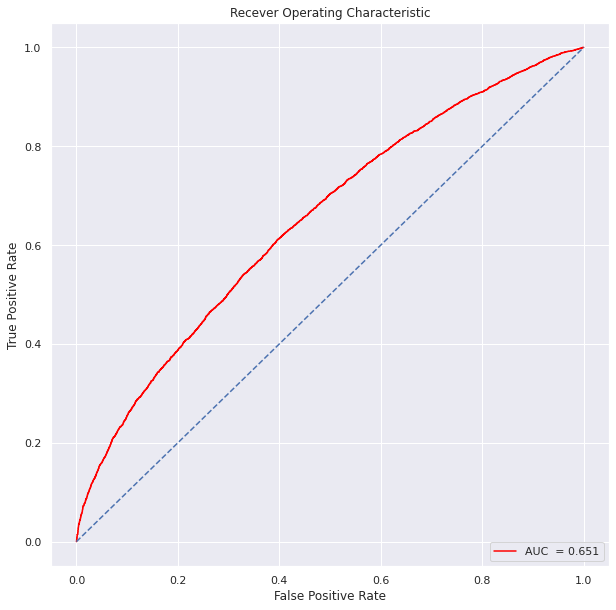

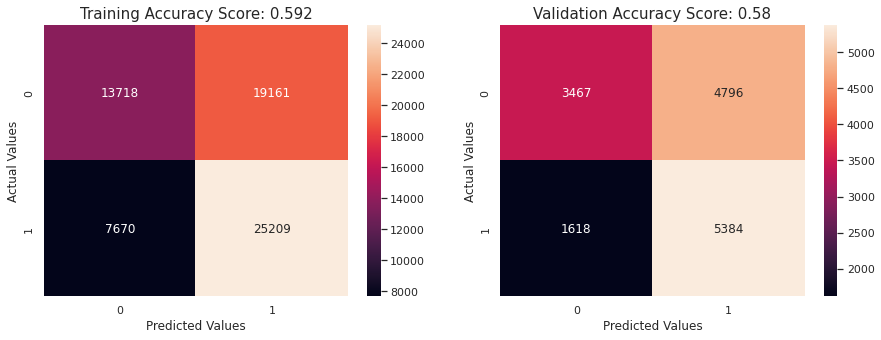


2.754385471343994s


In [30]:
s = time.time()

sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train, y_train)

y_train_preds = sgdc.predict_proba(X_train)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid)[:,1]

print('Stochastic Gradient Descent')
print('Metrics for Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, \
    sgdc_train_precision, sgdc_train_fscore, sgdc_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, \
     sgdc_valid_precision, sgdc_valid_fscore, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = sgdc.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = sgdc.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### Decision Tree

Decision Tree
Metrics for Training:
AUC: 0.719
accuracy: 0.654
recall: 0.667
precision: 0.650
fscore: 0.658
specificity: 0.639
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.669
accuracy: 0.621
recall: 0.639
precision: 0.578
fscore: 0.607
specificity: 0.602
prevalence: 0.459
 
The roc_auc is: 66.923%


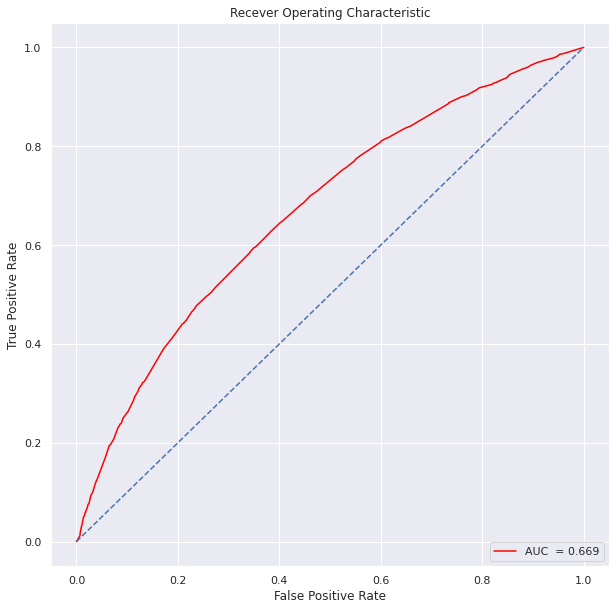

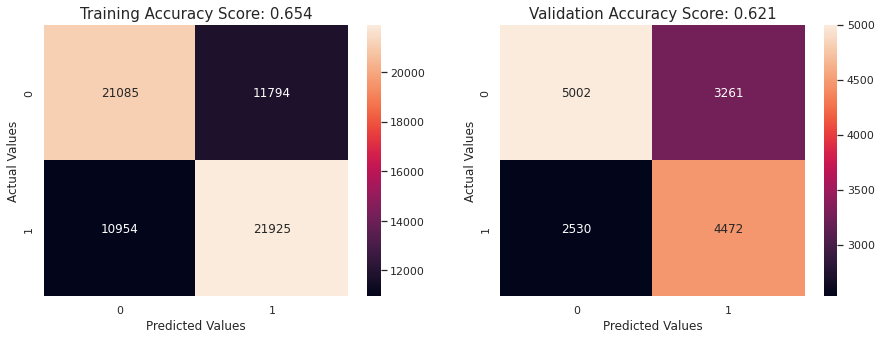


1.9665319919586182s


In [31]:
s= time.time()

dc_clf = DecisionTreeClassifier(random_state=42, max_depth = 10)
dc_clf.fit(X_train, y_train)

y_train_preds = dc_clf.predict_proba(X_train)[:,1]
y_valid_preds = dc_clf.predict_proba(X_valid)[:,1]

print('Decision Tree')
print('Metrics for Training:')
dc_clf_train_auc, dc_clf_train_accuracy, dc_clf_train_recall, \
    dc_clf_train_precision, dc_clf_train_fscore, dc_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
dc_clf_valid_auc, dc_clf_valid_accuracy, dc_clf_valid_recall, \
                dc_clf_valid_precision, dc_clf_train_fscore, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = dc_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = dc_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### Linear SVC

Linear SVC
Metrics for Training:
AUC: 0.616
accuracy: 0.534
recall: 0.097
precision: 0.766
fscore: 0.173
specificity: 0.970
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.617
accuracy: 0.569
recall: 0.099
precision: 0.718
fscore: 0.174
specificity: 0.967
prevalence: 0.459
 
The roc_auc is: 61.731%


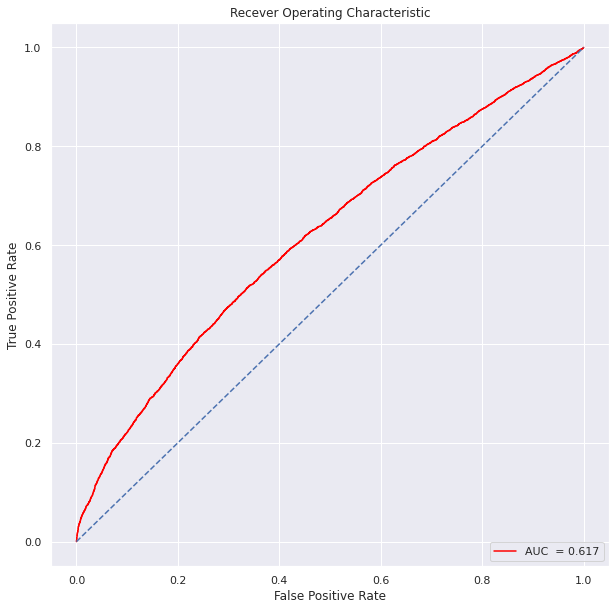

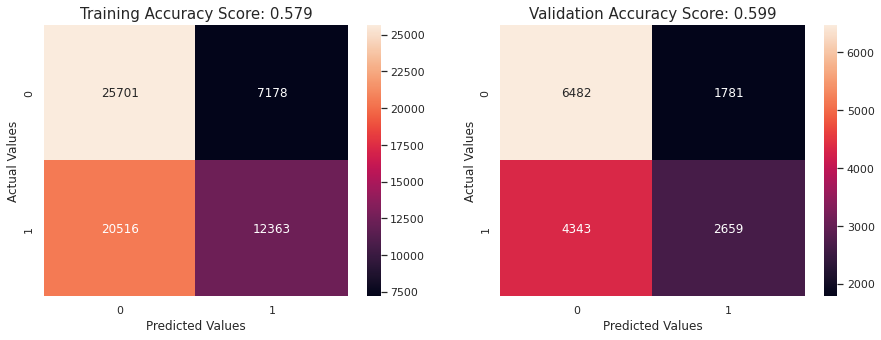


37.25290322303772s


In [32]:
s = time.time()

lsvc_clf = LinearSVC(random_state=111)
lsvc_clf.fit(X_train, y_train)

y_train_preds = lsvc_clf.decision_function(X_train)
y_valid_preds = lsvc_clf.decision_function(X_valid)

print('Linear SVC')
print('Metrics for Training:')
lsvc_clf_train_auc, lsvc_clf_train_accuracy, lsvc_clf_train_recall, \
    lsvc_clf_train_precision, lsvc_clf_train_fscore, lsvc_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
lsvc_clf_valid_auc, lsvc_clf_valid_accuracy, lsvc_clf_valid_recall, \
                lsvc_clf_valid_precision, lsvc_clf_train_fscore, lsvc_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = lsvc_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = lsvc_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### Random Forest 

Random Forest
Metrics for Training:
AUC: 0.685
accuracy: 0.634
recall: 0.581
precision: 0.649
fscore: 0.613
specificity: 0.686
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.675
accuracy: 0.630
recall: 0.573
precision: 0.602
fscore: 0.587
specificity: 0.679
prevalence: 0.459
 
The roc_auc is: 67.544%


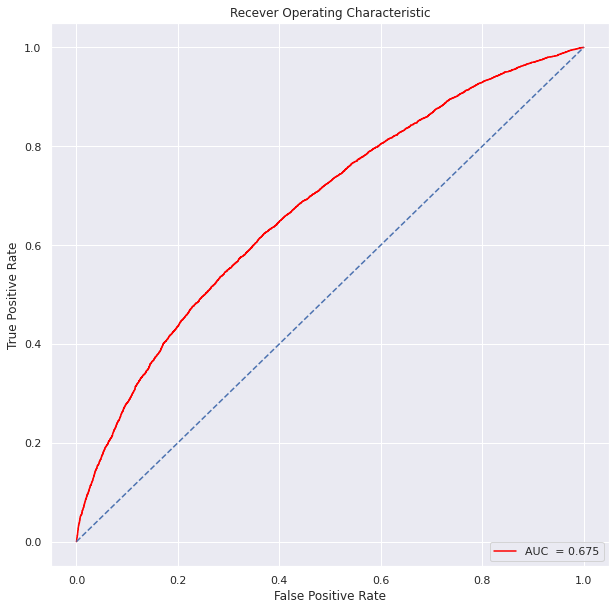

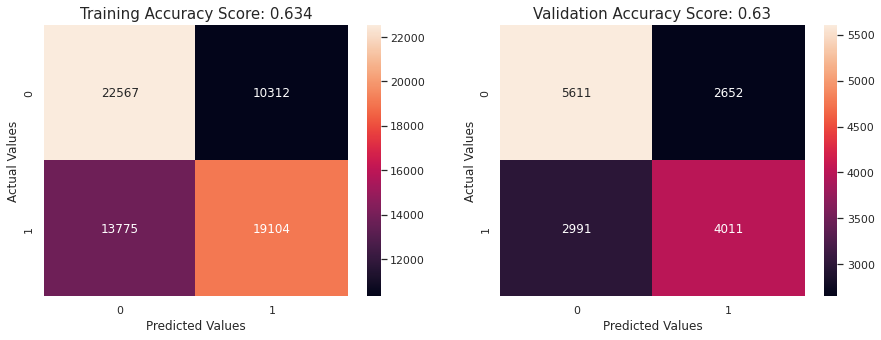


6.62146782875061s


In [33]:
s = time.time() 

rf_clf = RandomForestClassifier(random_state=111, max_depth = 6)
rf_clf.fit(X_train, y_train)

y_train_preds = rf_clf.predict_proba(X_train)[:,1]
y_valid_preds = rf_clf.predict_proba(X_valid)[:,1]

print('Random Forest')
print('Metrics for Training:')
rf_clf_train_auc, rf_clf_train_accuracy, rf_clf_train_recall, \
    rf_clf_train_precision, rf_clf_train_fscore, rf_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
rf_clf_valid_auc, rf_clf_valid_accuracy, rf_clf_valid_recall, \
                rf_clf_valid_precision, rf_clf_train_fscore, rf_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = rf_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = rf_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### Gradient Boost

Gradient Boosting
Metrics for Training:
AUC: 0.727
accuracy: 0.661
recall: 0.653
precision: 0.664
fscore: 0.658
specificity: 0.669
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.682
accuracy: 0.631
recall: 0.619
precision: 0.594
fscore: 0.606
specificity: 0.641
prevalence: 0.459
 
The roc_auc is: 68.165%


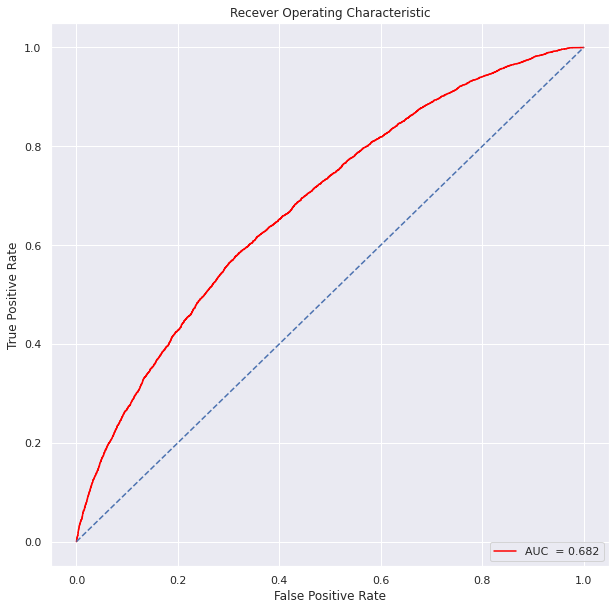

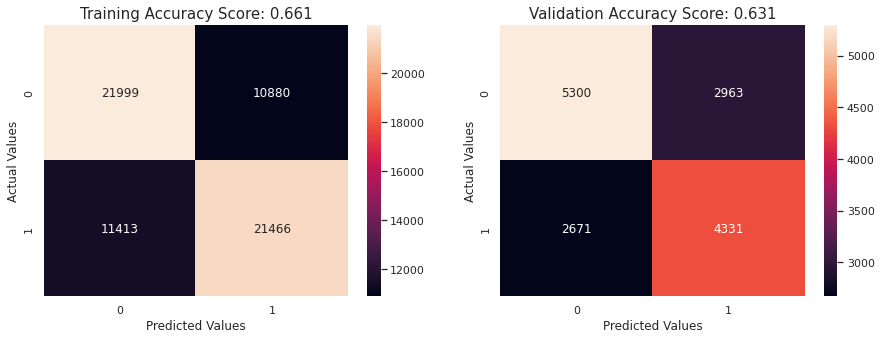


19.497087955474854s


In [34]:
s = time.time() 

gb_clf = GradientBoostingClassifier(n_estimators = 100, criterion='friedman_mse', learning_rate = 1.0, max_depth = 3, random_state = 111)
gb_clf.fit(X_train, y_train)

y_train_preds = gb_clf.predict_proba(X_train)[:,1]
y_valid_preds = gb_clf.predict_proba(X_valid)[:,1]

print('Gradient Boosting')
print('Metrics for Training:')
gb_clf_train_auc, gb_clf_train_accuracy, gb_clf_train_recall, \
    gb_clf_train_precision, gb_clf_train_fscore, gb_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
gb_clf_valid_auc, gb_clf_valid_accuracy, gb_clf_valid_recall, \
                gb_clf_valid_precision, gb_clf_train_fscore, gb_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = gb_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = gb_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')


### Catboost 

0:	learn: 0.6615292	total: 61.7ms	remaining: 12.3s
1:	learn: 0.6489962	total: 78.4ms	remaining: 7.76s
2:	learn: 0.6437672	total: 91.9ms	remaining: 6.04s
3:	learn: 0.6401861	total: 106ms	remaining: 5.2s
4:	learn: 0.6388406	total: 127ms	remaining: 4.95s
5:	learn: 0.6378663	total: 141ms	remaining: 4.56s
6:	learn: 0.6363677	total: 156ms	remaining: 4.29s
7:	learn: 0.6352325	total: 168ms	remaining: 4.04s
8:	learn: 0.6341866	total: 182ms	remaining: 3.86s
9:	learn: 0.6335237	total: 197ms	remaining: 3.74s
10:	learn: 0.6329234	total: 212ms	remaining: 3.64s
11:	learn: 0.6323817	total: 225ms	remaining: 3.53s
12:	learn: 0.6313134	total: 240ms	remaining: 3.45s
13:	learn: 0.6306157	total: 254ms	remaining: 3.38s
14:	learn: 0.6299027	total: 271ms	remaining: 3.34s
15:	learn: 0.6296259	total: 286ms	remaining: 3.29s
16:	learn: 0.6291016	total: 300ms	remaining: 3.23s
17:	learn: 0.6285578	total: 314ms	remaining: 3.18s
18:	learn: 0.6279525	total: 329ms	remaining: 3.13s
19:	learn: 0.6276378	total: 344ms	remai

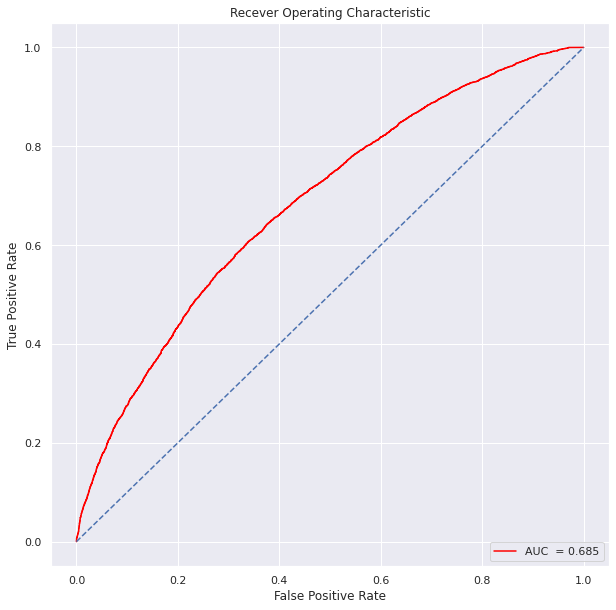

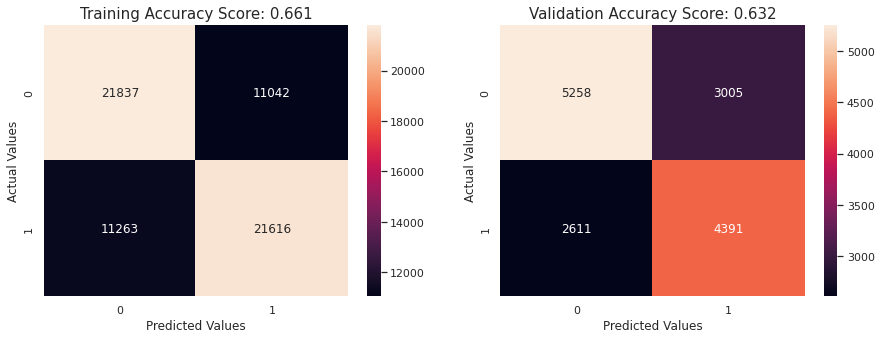


5.5091917514801025s


In [35]:
s = time.time() 

catb = CatBoostClassifier(iterations=200, depth=3, learning_rate=1.0, random_state = 111)
catb.fit(X_train, y_train)

y_train_preds = catb.predict_proba(X_train)[:,1]
y_valid_preds = catb.predict_proba(X_valid)[:,1]

print('Catboost')
print('Metrics for Training:')
catb_clf_train_auc, catb_clf_train_accuracy, catb_clf_train_recall, \
    catb_clf_train_precision, catb_clf_train_fscore, catb_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
catb_clf_valid_auc, catb_clf_valid_accuracy, catb_clf_valid_recall, \
                catb_clf_valid_precision, catb_clf_train_fscore, catb_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = catb.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = catb.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### XGBoost 

XGBoost
Metrics for Training:
AUC: 0.728
accuracy: 0.661
recall: 0.654
precision: 0.664
fscore: 0.659
specificity: 0.669
prevalence: 0.500
 
Metrics for Validation:
AUC: 0.682
accuracy: 0.628
recall: 0.619
precision: 0.591
fscore: 0.605
specificity: 0.636
prevalence: 0.459
 
The roc_auc is: 68.212%


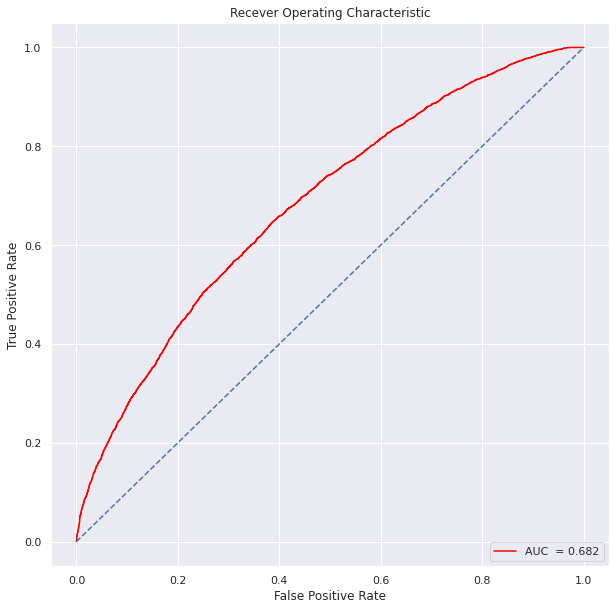

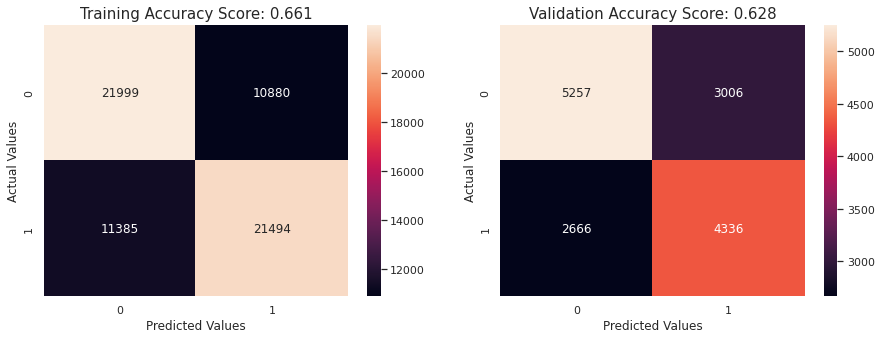


16.64820957183838s


In [36]:
s = time.time() 

xgb_clf = xgb.XGBClassifier(max_depth=3, learning_rate = 1.0, use_label_encoder = False,\
                            eval_metric = 'logloss')
xgb_clf.fit(X_train, y_train)

y_train_preds = xgb_clf.predict_proba(X_train)[:,1]
y_valid_preds = xgb_clf.predict_proba(X_valid)[:,1]

print('XGBoost')
print('Metrics for Training:')
xgb_clf_train_auc, xgb_clf_train_accuracy, xgb_clf_train_recall, \
    xgb_clf_train_precision, xgb_clf_train_fscore, xgb_clf_train_specificity = print_report(y_train,y_train_preds, thresh)

print('Metrics for Validation:')
xgb_clf_valid_auc, xgb_clf_valid_accuracy, xgb_clf_valid_recall, \
                xgb_clf_valid_precision, xgb_clf_train_fscore, xgb_clf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_valid_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'The roc_auc is: {round(roc_auc*100,3)}%')
plot_roc(roc_auc)

predictions = xgb_clf.predict(X_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = confusion_matrix(y_train, predictions)

predictions = xgb_clf.predict(X_valid)
val_score = round(accuracy_score(y_valid, predictions), 3)
cm_val = confusion_matrix(y_valid, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Training Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

e = time.time() 
print(f'\n{e-s}s')

### Hyperparameter tuning 

In [37]:
recall_scoring = make_scorer(recall_score)

### Decision Tree Tuning

In [39]:
s = time.time()

dc_grid = {'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

dc_random = RandomizedSearchCV(estimator = dc_clf, param_distributions = dc_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

dc_random.fit(X_train, y_train)

dc_random.best_params_

dc_hp_preds = dc_random.best_estimator_.predict(X_valid)
dc_hp_preds_proba = dc_random.best_estimator_.predict_proba(X_valid)[:,1]
#y_train_preds = dc_random.predict_proba(X_train)[:,1]
#y_valid_preds = dc_random.predict_proba(X_valid)[:,1]

print(f'AUC: {round(roc_auc_score(y_valid, dc_hp_preds_proba),3)}')
print(f'Recall: {round(recall_score(y_valid, dc_hp_preds),3)}')
e = time.time() 
print(f'\n{e-s}s')

Fitting 2 folds for each of 20 candidates, totalling 40 fits
AUC: 0.525
Recall: 0.792

4.442315101623535s


### Random Forest Tuning

In [42]:
s = time.time()

rf_grid = {'n_estimators':range(200,1000,200), # number of trees
           'max_features':['auto','sqrt'], # maximum number of features to use at each split
           'max_depth':range(1,11,1), # maximum depth of the tree
           'min_samples_split':range(2,10,2), # minimum number of samples to split a node
           'criterion':['gini','entropy']} # criterion for evaluating a split

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_grid, 
                               n_iter = 20, cv = 2, scoring=recall_scoring,
                               verbose = 1, random_state = 111)

rf_random.fit(X_train, y_train)

rf_random.best_params_

rf_hp_preds = rf_random.best_estimator_.predict(X_valid)
rf_hp_preds_proba = rf_random.best_estimator_.predict_proba(X_valid)[:,1]


print(f'AUC: {round(roc_auc_score(y_valid, rf_hp_preds_proba),3)}%')
print(f'Recall: {round(recall_score(y_valid, rf_hp_preds),3)}%')

e = time.time() 
print(f'\n{e-s}s')

Fitting 2 folds for each of 20 candidates, totalling 40 fits
AUC: 0.686%
Recall: 0.601%

346.9587585926056s


### Catboost Tuning

In [41]:
s = time.time()

catb_params={"iterations":[200,500,1000],
            "learning_rate":[0.05,0.1],
            "depth":[4,5,8]}

catb_cv_model=GridSearchCV(catb,catb_params, cv=3, n_jobs=-1,  verbose=2).fit(X_train,y_train)

catb_params={"iterations":[200,500,1000],
            "learning_rate":[0.05,0.1],
            "depth":[4,5,8]}  

#y_train_preds = catb.predict_proba(X_train)[:,1]
#y_valid_preds = catb.predict_proba(X_valid)[:,1]

catb_hp_preds = catb_cv_model.best_estimator_.predict(X_valid)
catb_hp_preds_proba = catb_cv_model.best_estimator_.predict_proba(X_valid)[:,1]

print(f'AUC: {round(roc_auc_score(y_valid, catb_hp_preds_proba),3)}')
print(f'Recall: {round(recall_score(y_valid, catb_hp_preds),3)}')

e = time.time() 
print(f'\n{e-s}s')

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0:	learn: 0.6885332	total: 25.6ms	remaining: 25.6s
1:	learn: 0.6853610	total: 46.4ms	remaining: 23.1s
2:	learn: 0.6817878	total: 64ms	remaining: 21.3s
3:	learn: 0.6793321	total: 81.6ms	remaining: 20.3s
4:	learn: 0.6768150	total: 97.6ms	remaining: 19.4s
5:	learn: 0.6745734	total: 113ms	remaining: 18.6s
6:	learn: 0.6726089	total: 129ms	remaining: 18.3s
7:	learn: 0.6709039	total: 144ms	remaining: 17.8s
8:	learn: 0.6692940	total: 163ms	remaining: 17.9s
9:	learn: 0.6677194	total: 178ms	remaining: 17.6s
10:	learn: 0.6663235	total: 194ms	remaining: 17.4s
11:	learn: 0.6642701	total: 209ms	remaining: 17.2s
12:	learn: 0.6625598	total: 232ms	remaining: 17.6s
13:	learn: 0.6614333	total: 249ms	remaining: 17.6s
14:	learn: 0.6602840	total: 266ms	remaining: 17.4s
15:	learn: 0.6588741	total: 281ms	remaining: 17.3s
16:	learn: 0.6579730	total: 297ms	remaining: 17.2s
17:	learn: 0.6571434	total: 311ms	remaining: 17s
18:	learn: 0.6555660	total: 32

### XGB Boost Tuning

In [38]:
s = time.time()

xgb_grid = params = {
        'min_child_weight': [1, 5, 8, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5]
        } # criterion for evaluating a split

xgb_random = GridSearchCV(estimator = xgb_clf, param_grid = xgb_grid, 
                               cv = 2, scoring = recall_scoring,
                               verbose = 1)

xgb_random.fit(X_train, y_train)

xgb_random.best_params_

xgb_hp_preds = xgb_random.best_estimator_.predict(X_valid)
xgb_hp_preds_proba = xgb_random.best_estimator_.predict_proba(X_valid)[:,1]


print(f'AUC: {round(roc_auc_score(y_valid, xgb_hp_preds_proba),3)}')
print(f'Recall: {round(recall_score(y_valid, xgb_hp_preds),3)}')

e = time.time() 
print(f'\n{e-s}s')

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
AUC: 0.682
Recall: 0.623

13359.567955255508s
